In [173]:
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
# fix issues with tex
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams.update(mpl.rcParamsDefault)
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import scipy as sp
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist
from sklearn.metrics import (
    fowlkes_mallows_score, 
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix
)
from sklearn.datasets import make_blobs
from sklearn.exceptions import ConvergenceWarning
import seaborn as sns


from setup import init_particles, init_A, init_V
from update_rules import update_state, update_A, update_V
from visualize import visualize

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
def init_V(d):
    V = 2*np.random.rand(d, d)-np.ones((d, d))
    V = np.matmul(V, V.T)
    return V

def init_A(d):
    A = 2*np.random.rand(d, d)-np.ones((d, d))
    A = np.matmul(A, A.T)
    return A

def init_x(n, d, num_steps, max_val):
    x0 = np.random.uniform(low=-max_val, high=max_val, size=(n, d))
    # normalize
    x0 /= np.linalg.norm(x0, axis=1)[:, np.newaxis]
    x = np.zeros(shape=(n, num_steps, d))
    x[:, 0, :] = x0
    return x

def reset(n, d, num_steps, scale_a, scale_v, max_val, AV_as_eye=(True, True)):
    if AV_as_eye[0]:
        A = np.eye(d)
    else:
        A = init_A_eye(d) * scale_a
        
    if AV_as_eye[1]:
        V = np.eye(d) * scale_v
    else:
        V = init_V(d) * scale_v
        
    x = init_x(n, d, num_steps, max_val)
#     V = np.random.rand(d, d)
#     V = np.abs(V)
    
    return x, A, V

def euler_update(attention, V, x, n, dt):
    # TODO: add additional update rules to particle location based on FFN, norm, etc
    for i in range(n):
        dlst = np.array([attention[i][j]*np.matmul(V, x[j][l]) for j in range(n)])
        # sum over j
        dynamics = np.sum(dlst, axis=0)
        # Euler scheme
        x[i][l+1] = x[i][l] + dt*dynamics
    return x

def rk4(attention, V, x, n, dt):
    """Never uses attention matric in its weight update, just self-interaction, also more stable"""
    for i in range(n):
        k1 = dt*np.matmul(V, x[i][l])
        k2 = dt*np.matmul(V, x[i][l] + 0.5*k1)
        k3 = dt*np.matmul(V, x[i][l] + 0.5*k2)
        k4 = dt*np.matmul(V, x[i][l] + k3)
        dynamics = (1/6)*(k1 + 2*k2 + 2*k3 + k4)
        x[i][l+1] = x[i][l] + dynamics
    return x

def get_dynamics(z_curr, attention, V, i):
    """
    - Returns: the dynamics z'(t) = (z_1'(t), ... , z_n'(t)) at some time-step t.
    """
    
    dlst = np.array([attention[i][j]*np.matmul(V, z_curr[j]-z_curr[i]) for j in range(n)])
    return np.sum(dlst, axis=0)

def rk4_with_attention(attention, V, x, n, dt):
    """NOTE: without the relative distances between particles: z_curr[j] and z_curr[i] there isn't local clusttering
    and we don't see those 3 manifold saddlepoint, just converges to 2 or even 1 if within the original beta"""
    x_next = np.zeros((n, d))
    for i in range(n):
        k1 = dt * get_dynamics(x[:, l, :], attention, V, i)
        k2 = dt * get_dynamics(x[:, l, :] + k1 / 2, attention, V, i)
        k3 = dt * get_dynamics(x[:, l, :] + k2 / 2, attention, V, i)
        k4 = dt * get_dynamics(x[:, l, :] + k3, attention, V, i)

        x_next[i] = x[i][l] + (k1 + 2*k2 + 2*k3 + k4) / 6

    return x_next

In [175]:
# classification task methods

def init_x_clusters(n, d, num_steps):
    """Two clusters by splitting particles down the middle"""
    n_clusters = 2
    noise = 0.2
    cluster_sep = 2.0
    # clusters mirrored across the origin
    # cluster_centers = [np.array([-cluster_sep/2] * d), np.array([cluster_sep/2] * d)]
    cluster_centers = [np.array([0] * d), np.array([10] * d)]
    x0 = np.zeros((n, d))
    for i in range(n):
        cluster_idx = i % n_clusters
        x0[i] = cluster_centers[cluster_idx] + np.random.normal(scale=noise, size=d)
    x = np.zeros((n, num_steps, d))
    x[:, 0, :] = x0
    return x

def init_x_blobs(n, d, num_steps, centers=None, cluster_std=1.0, random_state=None):
    """
    centers: float or ararylike
    - x (np.ndarray): Initialized particle positions of shape (n, num_steps, d).
    """
    if centers is None:
        centers = n_classes  # Default to n_classes centers

    # Generate blob data
    x0, generated_labels = make_blobs(n_samples=n, centers=centers, n_features=d, 
                                     cluster_std=cluster_std, random_state=random_state)

    # normalize
    x0 /= np.linalg.norm(x0, axis=1)[:, np.newaxis]
    
    x = np.zeros((n, num_steps, d))
    x[:, 0, :] = x0

    return x, generated_labels

def compute_class_means_on_hypersphere(x, labels, radius=1.0):
    """
    Compute the mean position for each class and project it onto a hypersphere.
    return dict{class} mean projected on sphere
    """
    classes = np.unique(labels)
    class_means_normalized = {}

    for cls in classes:
        class_indices = np.where(labels == cls)[0]
        mean_vector = np.mean(x[class_indices, 0, :], axis=0)
        norm = np.linalg.norm(mean_vector)
        if norm == 0:
            normalized_mean = mean_vector  # Avoid division by zero
        else:
            normalized_mean = (mean_vector / norm) * radius
        class_means_normalized[cls] = normalized_mean

    return class_means_normalized


def visualize_initial_clusters(x, labels, class_means_normalized, d=2, base_filename='init_clusters'):
    if d == 2:
        plt.figure(figsize=(8, 6))
        colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan']
        for cls in np.unique(labels):
            cluster_points = x[labels == cls, 0, :]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                        c=colors[cls % len(colors)], label=f'Class {cls}', alpha=0.6, edgecolors='w')
            plt.scatter(class_means_normalized[cls][0], class_means_normalized[cls][1], 
                        c='black', marker='X', s=100, label=f'Class {cls} Mean')
        plt.legend()
        plt.title('Initial Clusters and Class Means on 2D Hypersphere')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.grid(True)
        plt.show()
    elif d == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlim3d(-1.1, 1.1)
        ax.set_ylim3d(-1.1, 1.1)
        ax.set_zlim3d(-1.1, 1.1)
        
        label_size = 8
        plt.rcParams['xtick.labelsize'] = label_size
        plt.rcParams['ytick.labelsize'] = label_size 

        ax.set_aspect('equal', adjustable='box')
        plt.rc('font', family='serif')
                
        colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan']
        for cls in np.unique(labels):
            cluster_points = x[labels == cls, 0, :]
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], 
                       c=colors[cls % len(colors)], label=f'Class {cls}', alpha=0.6, edgecolors='w')
            ax.scatter(class_means_normalized[cls][0], class_means_normalized[cls][1], 
                       class_means_normalized[cls][2], 
                       c='black', marker='X', s=100, label=f'Class {cls} Mean')
        ax.legend()
        ax.set_title('Initial Clusters and Class Means on 3D Hypersphere')
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        ax.set_zlabel('Dimension 3')
        
        default_azim = 30  

        # the range of rotation around the default_azim
        rotation_range = 30
        total_frames = num_steps
        
        angle = default_azim + rotation_range * (t/total_frames - 0.5)  # will go from -15 to +15 degrees
        ax.view_init(elev=10, azim=angle)
    
        ax.grid(False)
        plt.locator_params(nbins=4)
        dir_path = 'init_clusters'
        os.makedirs(dir_path, exist_ok=True)
        plt.savefig(os.path.join(dir_path, base_filename + "{}.png".format(t)), 
                    format='png', 
                    bbox_inches='tight',
                    dpi=500)
        
    else:
        print("Visualization not supported for dimensions other than 2 or 3.")
        
    plt.clf()
    plt.close()


## Original Experiments

Low Rank Analysis and cluster divergence

In [176]:
def compute_attention(A, x, i, j, n):
    """
    Compute attention weight using a softmax-like mechanism for numerical stability.
    
    Args:
        A (np.ndarray): Transformation matrix A of shape (d, d).
        x (np.ndarray): Current particle positions of shape (n, d).
        i (int): Index of the query particle.
        j (int): Index of the key particle.
        n (int): Total number of particles.
    
    Returns:
        float: Attention weight between particle i and j.
    """
    scores = [np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l]) for k in range(n)]
    # Apply softmax in a numerically stable way
    max_score =  np.max(scores) # np.zeros_like(scores)
    exp_scores = np.exp(scores - max_score)
    sum_exp = np.sum(exp_scores)
    attention_weight = 1 / sum_exp
    return attention_weight

def compute_attn_mos(A, x, i, j, n, h, pi):
    attention = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                continue  # Optional: No self-attention
            scores = []
            for k in range(K):
                # Compute similarity score for mixture component k
                # Adjust the formula based on MoS requirements
                # Here, a simplified dot product is used; adapt as needed
                score = np.dot(h[k], A @ x[i, l]) * np.dot(A @ x[i, l], x[j, l] - x[i, l])
                scores.append(score)
            scores = np.array(scores)  # Shape: (K,)
            # Apply softmax to scores for numerical stability
            max_score = np.max(scores)
            exp_scores = np.exp(scores - max_score)
            softmax_scores = exp_scores / np.sum(exp_scores)
            # Combine softmax scores using mixture weights pi
            attention[i, j] = np.dot(pi, softmax_scores)
    return attention


def vanilla_attn(A, x, i, j, n):
    """from original implementation"""
    return [np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]


def l2_attention(A, x, l, sigma=1.0):
    """
    Compute the full attention matrix at time step l using the L2 norm.

    Args:
        A (np.ndarray): Transformation matrix A of shape (d, d).
        x (np.ndarray): Particle positions of shape (n, num_steps, d).
        l (int): Current time step index.
        sigma (float): Scaling factor for the L2-based attention.

    Returns:
        np.ndarray: Attention matrix of shape (n, n) at time step l.
    """
    n = x.shape[0]
    # Extract positions at time step l
    x_l = x[:, l, :]  # Shape: (n, d)
    
    # Compute transformed queries
    Q = x_l @ A.T  # Shape: (n, d)
    K = x_l  # Shape: (n, d)
    
    # Compute pairwise squared L2 distances between queries and keys
    # Efficiently compute (Q_i - K_j)^2 for all i, j
    Q_expanded = Q[:, np.newaxis, :]  # Shape: (n, 1, d)
    K_expanded = K[np.newaxis, :, :]  # Shape: (1, n, d)
    distances = np.sum((Q_expanded - K_expanded) ** 2, axis=2)  # Shape: (n, n)
    
    # Compute attention scores using Gaussian kernel
    scores = np.exp(-distances / (2 * sigma ** 2))  # Shape: (n, n)
    
    # Normalize scores to get attention weights
    attention = scores / np.sum(scores, axis=1, keepdims=True)  # Shape: (n, n)
    return attention


def layer_normalize(x, radius=1):
    """Normalize each particle's position vector to have a norm equal to the sphere's radius"""
    norms = np.linalg.norm(x, axis=1, keepdims=True)
    x_normalized = (x / norms) * radius
    return x_normalized


def sphere_update(A, V, z, l, beta=1):
    denominator = True
    Az = np.matmul(A, z[:, l, :].T)
    exp_beta_dot = np.exp(beta * np.matmul(Az.T, Az))
    if denominator:
        attention = exp_beta_dot / exp_beta_dot.sum(axis=1)[:, np.newaxis]
    else:
        attention = exp_beta_dot / n
    
    dlst = np.matmul(attention, np.matmul(V, z[:, l, :].T).T)
    dynamics = dlst
    z[:, l+1, :] = z[:, l, :] + dt * dynamics
    z[:, l+1, :] = z[:, l+1, :] / np.linalg.norm(z[:, l+1, :], axis=1)[:, np.newaxis]
    return z, attention

In [177]:
# Parameters
n = 20          # Total number of particles
T = 200          # Total simulation time
dt = 0.1        # Time step
num_steps = int(T/dt) + 1
d = 3           # Dimensionality (2D)
max_val = 1 # spread from which x is chosen?

integration_time = np.linspace(0, T, num_steps)

# for adding classification objective to evolve A and V
classification_task = True
learning_rate = 0.001
num_classes = 3
b = 0.0 # option bias term

# for MOS experimetns
K = 2 # num mixture compoennts
pi = np.random.rand(K)
pi /= np.sum(pi)  # Normalize to sum to 1
h = np.random.randn(K, d)  # Context vectors

use_lnorm = True
beta = 10 # for spherical update

calc_k_means = True
kmeans_cadence = 5

# visualization cadence params
viz_cadence = 5
result_dir = 'post-ln-results_3d'

os.makedirs(result_dir, exist_ok=True)

base_filename = '3d_fig'
save_fig=False
color= '#3a4cc1'

{0: array([-0.50646438, -0.31047671,  0.80442404]), 1: array([-0.12065606, -0.79490343, -0.59461807]), 2: array([ 0.59208288, -0.58489561, -0.55437802])}


<Figure size 600x500 with 0 Axes>

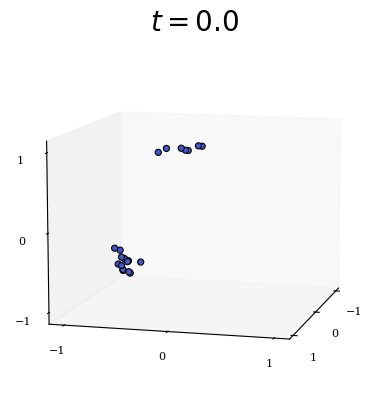

Time 0.00: Cluster Centers:
[[-0.50004455 -0.30654117  0.79422734]
 [ 0.59048836 -0.58332044 -0.55288504]
 [-0.11984952 -0.78958982 -0.59064328]]
Time 0.00: ARI = 1.0000, NMI = 1.0000, FMI = 1.0000, Silhouette Score = 0.8359, Distance between first two centers = 1.7552


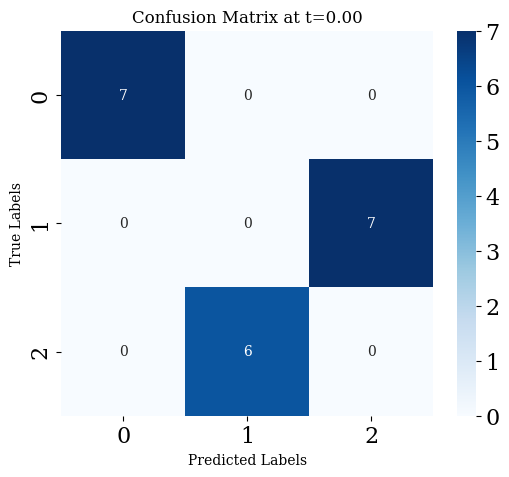

Time 0.00: Loss = 1.3014406879987566
Time 0.10: Loss = 1.3039363473801031
Time 0.20: Loss = 1.3064450907321103
Time 0.30: Loss = 1.3089796594551868
Time 0.40: Loss = 1.3115525626551578
Time 0.50: Loss = 1.3141760810596776
Time 0.60: Loss = 1.3168622703279245
Time 0.70: Loss = 1.3196229609610897
Time 0.80: Loss = 1.3224697493227517
Time 0.90: Loss = 1.325413971784259
Time 1.00: Loss = 1.3284666519451285
Time 1.10: Loss = 1.3316384092285631
Time 1.20: Loss = 1.3349393158505802
Time 1.30: Loss = 1.3383786882445823
Time 1.40: Loss = 1.3419647987412495
Time 1.50: Loss = 1.3457044941912544
Time 1.60: Loss = 1.3496027111330073
Time 1.70: Loss = 1.3536618832156444
Time 1.80: Loss = 1.3578812472457522
Time 1.90: Loss = 1.362256070678674
Time 2.00: Loss = 1.3667768461723875
Time 2.10: Loss = 1.3714285269296782
Time 2.20: Loss = 1.3761899062826966
Time 2.30: Loss = 1.381033269164106
Time 2.40: Loss = 1.385924451374183
Time 2.50: Loss = 1.3908234235053172
Time 2.60: Loss = 1.3956854622398507
Time 

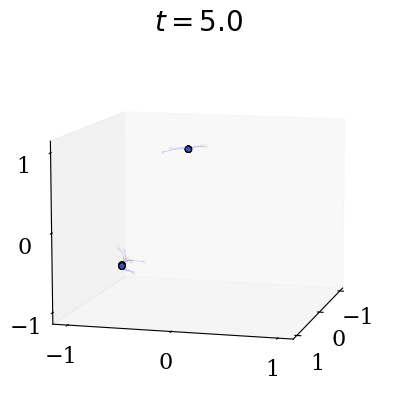

Time 5.00: Cluster Centers:
[[-0.54663417 -0.30334021  0.78049548]
 [ 0.2113712  -0.76098494 -0.61336816]
 [ 0.26464258 -0.74621708 -0.61083602]]
Time 5.00: ARI = 1.0000, NMI = 1.0000, FMI = 1.0000, Silhouette Score = 0.9694, Distance between first two centers = 1.6513


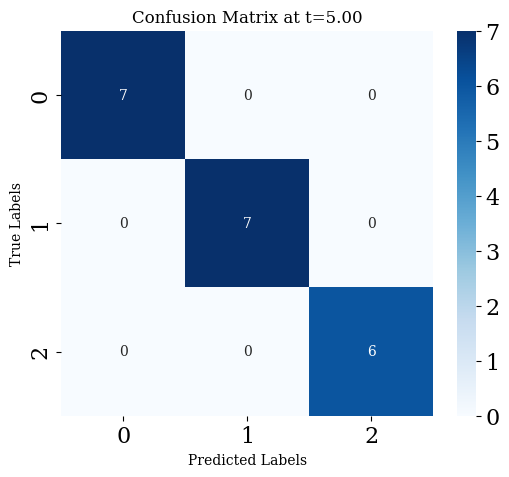

Time 5.00: Loss = 1.4383524905686653
Time 5.10: Loss = 1.437315851908986
Time 5.20: Loss = 1.4361550870949387
Time 5.30: Loss = 1.4348786401235993
Time 5.40: Loss = 1.4334941793377087
Time 5.50: Loss = 1.4320086563204248
Time 5.60: Loss = 1.4304283635843906
Time 5.70: Loss = 1.4287589898959987
Time 5.80: Loss = 1.427005672529833
Time 5.90: Loss = 1.4251730460725731
Time 6.00: Loss = 1.4232652876224992
Time 6.10: Loss = 1.4212861583854919
Time 6.20: Loss = 1.4192390417704313
Time 6.30: Loss = 1.4171269781509357
Time 6.40: Loss = 1.4149526964974255
Time 6.50: Loss = 1.4127186431016772
Time 6.60: Loss = 1.4104270076213283
Time 6.70: Loss = 1.4080797466684962
Time 6.80: Loss = 1.40567860515791
Time 6.90: Loss = 1.4032251356178782
Time 7.00: Loss = 1.4007207156535926
Time 7.10: Loss = 1.3981665637377065
Time 7.20: Loss = 1.395563753488585
Time 7.30: Loss = 1.3929132265824857
Time 7.40: Loss = 1.3902158044325315
Time 7.50: Loss = 1.3874721987548146
Time 7.60: Loss = 1.384683021130373
Time 7.

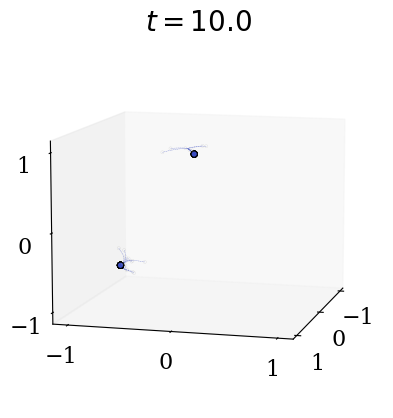

Time 10.00: Cluster Centers:
[[-0.66290518 -0.27805211  0.69515735]
 [ 0.30883303 -0.74679161 -0.58900293]
 [ 0.30936001 -0.74661252 -0.58895342]]
Time 10.00: ARI = 1.0000, NMI = 1.0000, FMI = 1.0000, Silhouette Score = 0.9699, Distance between first two centers = 1.6772


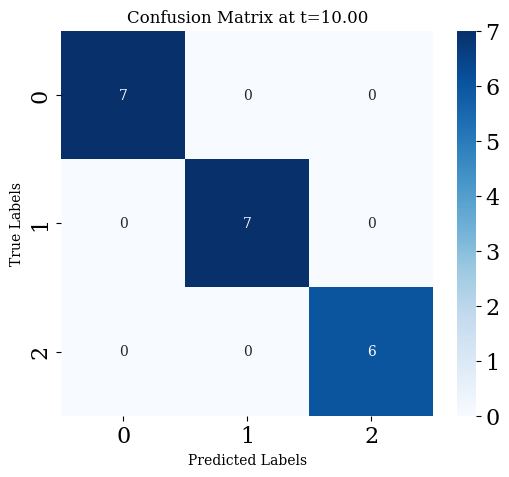

Time 10.00: Loss = 1.3045209555867998
Time 10.10: Loss = 1.3006178864906037
Time 10.20: Loss = 1.2966672057110042
Time 10.30: Loss = 1.2926684940102846
Time 10.40: Loss = 1.2886213199882461
Time 10.50: Loss = 1.284525240780726
Time 10.60: Loss = 1.2803798027163755
Time 10.70: Loss = 1.2761845419373212
Time 10.80: Loss = 1.2719389849889415
Time 10.90: Loss = 1.267642649383656
Time 11.00: Loss = 1.2632950441433082
Time 11.10: Loss = 1.2588956703244665
Time 11.20: Loss = 1.2544440215307031
Time 11.30: Loss = 1.2499395844157317
Time 11.40: Loss = 1.2453818391810612
Time 11.50: Loss = 1.240770260071686
Time 11.60: Loss = 1.2361043158731744
Time 11.70: Loss = 1.2313834704133917
Time 11.80: Loss = 1.226607183071988
Time 11.90: Loss = 1.2217749093006829
Time 12.00: Loss = 1.2168861011572873
Time 12.10: Loss = 1.211940207856348
Time 12.20: Loss = 1.2069366763392066
Time 12.30: Loss = 1.201874951866245
Time 12.40: Loss = 1.1967544786339945
Time 12.50: Loss = 1.1915747004197803
Time 12.60: Loss =

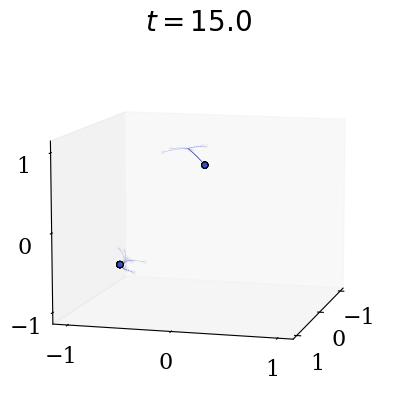

Time 15.00: Cluster Centers:
[[-0.82687389 -0.21511889  0.51961854]
 [ 0.46883322 -0.70253276 -0.53539063]
 [ 0.4688385  -0.70253009 -0.53538952]]
Time 15.00: ARI = 1.0000, NMI = 1.0000, FMI = 1.0000, Silhouette Score = 0.9699, Distance between first two centers = 1.7405


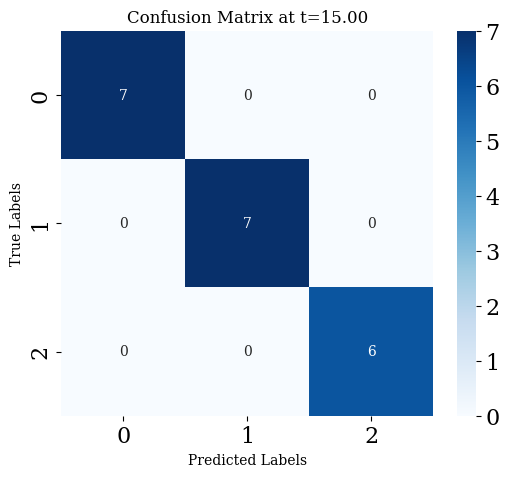

Time 15.00: Loss = 1.0412699443779987
Time 15.10: Loss = 1.0343726405775482
Time 15.20: Loss = 1.027404365244997
Time 15.30: Loss = 1.0203649948594011
Time 15.40: Loss = 1.0132544454606334
Time 15.50: Loss = 1.0060726748967002
Time 15.60: Loss = 0.9988196851151798
Time 15.70: Loss = 0.9914955244939618
Time 15.80: Loss = 0.9841002902058686
Time 15.90: Loss = 0.9766341306111272
Time 16.00: Loss = 0.9690972476709957
Time 16.10: Loss = 0.9614898993752281
Time 16.20: Loss = 0.953812402175366
Time 16.30: Loss = 0.9460651334152056
Time 16.40: Loss = 0.9382485337491044
Time 16.50: Loss = 0.9303631095381233
Time 16.60: Loss = 0.9224094352133655
Time 16.70: Loss = 0.9143881555952179
Time 16.80: Loss = 0.906299988156599
Time 16.90: Loss = 0.8981457252177296
Time 17.00: Loss = 0.88992623605941
Time 17.10: Loss = 0.8816424689412777
Time 17.20: Loss = 0.8732954530110992
Time 17.30: Loss = 0.8648863000907598
Time 17.40: Loss = 0.856416206324323
Time 17.50: Loss = 0.8478864536733136
Time 17.60: Loss =

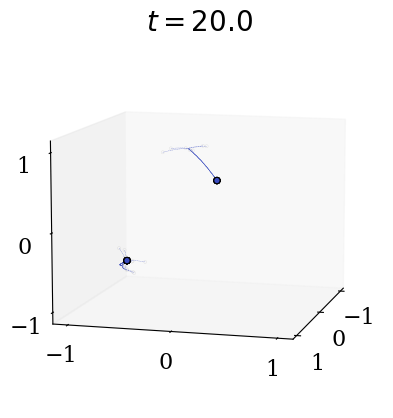

Time 20.00: Cluster Centers:
[[-0.94850123 -0.12414818  0.29143205]
 [ 0.72930586 -0.54981505 -0.40720558]
 [ 0.7293059  -0.54981501 -0.40720556]]
Time 20.00: ARI = 1.0000, NMI = 1.0000, FMI = 1.0000, Silhouette Score = 0.9407, Distance between first two centers = 1.8666


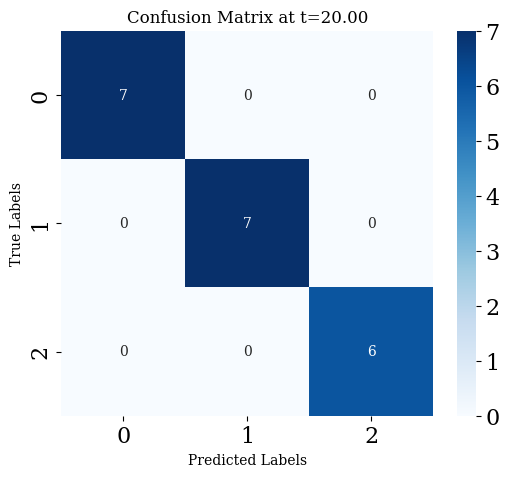

Time 20.00: Loss = 0.6208101018389135
Time 20.10: Loss = 0.6114639524558935
Time 20.20: Loss = 0.6021242389239034
Time 20.30: Loss = 0.5927942501814198
Time 20.40: Loss = 0.5834772912043263
Time 20.50: Loss = 0.5741766767461056
Time 20.60: Loss = 0.5648957249747358
Time 20.70: Loss = 0.5556377510348709
Time 20.80: Loss = 0.5464060605647336
Time 20.90: Loss = 0.5372039431977604
Time 21.00: Loss = 0.528034666079406
Time 21.10: Loss = 0.5189014674296126
Time 21.20: Loss = 0.5098075501813095
Time 21.30: Loss = 0.5007560757248913
Time 21.40: Loss = 0.4917501577879662
Time 21.50: Loss = 0.48279285647874814
Time 21.60: Loss = 0.47388717252032153
Time 21.70: Loss = 0.46503604170163176
Time 21.80: Loss = 0.4562423295694719
Time 21.90: Loss = 0.4475088263839674
Time 22.00: Loss = 0.43883824235811736
Time 22.10: Loss = 0.43023320319987024
Time 22.20: Loss = 0.4216962459730073
Time 22.30: Loss = 0.41322981529080327
Time 22.40: Loss = 0.404836259854072
Time 22.50: Loss = 0.3965178293427952
Time 22.

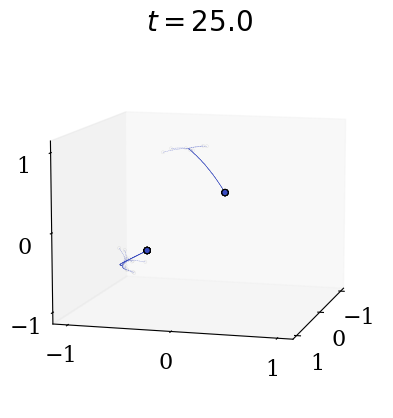

Time 25.00: Cluster Centers:
[[-0.99098527 -0.05332825  0.12289948]
 [ 0.93378056 -0.28942712 -0.21044194]
 [ 0.93378056 -0.28942712 -0.21044194]]
Time 25.00: ARI = 0.5035, NMI = 0.6245, FMI = 0.6697, Silhouette Score = 0.3399, Distance between first two centers = 1.9676


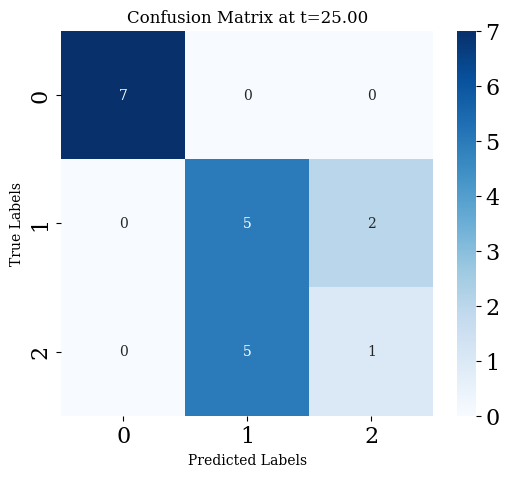

Time 25.00: Loss = 0.21736669713807527
Time 25.10: Loss = 0.21144262305149408
Time 25.20: Loss = 0.20561492780211443
Time 25.30: Loss = 0.19988313642351876
Time 25.40: Loss = 0.19424671086971496
Time 25.50: Loss = 0.18870505336216364
Time 25.60: Loss = 0.18325750971820007
Time 25.70: Loss = 0.17790337264996847
Time 25.80: Loss = 0.17264188502387662
Time 25.90: Loss = 0.16747224307145364
Time 26.00: Loss = 0.1623935995433738
Time 26.10: Loss = 0.1574050667992534
Time 26.20: Loss = 0.15250571982666786
Time 26.30: Loss = 0.14769459918363273
Time 26.40: Loss = 0.1429707138595706
Time 26.50: Loss = 0.13833304405052418
Time 26.60: Loss = 0.13378054384507523
Time 26.70: Loss = 0.12931214381810172
Time 26.80: Loss = 0.1249267535301217
Time 26.90: Loss = 0.12062326393056437
Time 27.00: Loss = 0.11640054966384897
Time 27.10: Loss = 0.11225747127765659
Time 27.20: Loss = 0.10819287733324323
Time 27.30: Loss = 0.10420560641806442
Time 27.40: Loss = 0.10029448906136648
Time 27.50: Loss = 0.09645834

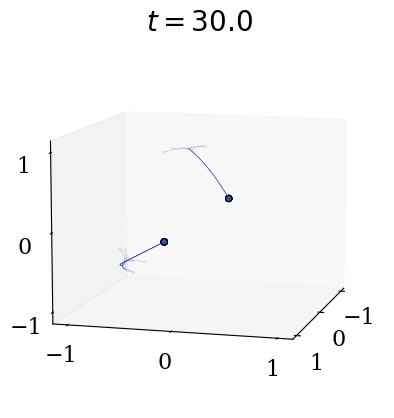

Time 30.00: Cluster Centers:
[[-0.99892114 -0.01867626  0.04251765]
 [ 0.99132471 -0.10675269 -0.07667584]
 [-0.99892114 -0.01867626  0.04251765]]
Time 30.00: ARI = 0.4118, NMI = 0.6532, FMI = 0.6390, Silhouette Score = 0.6375, Distance between first two centers = 1.9958


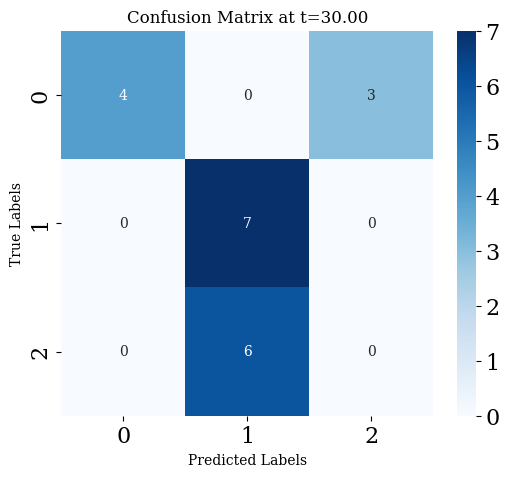

Time 30.00: Loss = 0.021520074284403584
Time 30.10: Loss = 0.01923124416080645
Time 30.20: Loss = 0.01698765934001263
Time 30.30: Loss = 0.014788386683131673
Time 30.40: Loss = 0.012632508043057216
Time 30.50: Loss = 0.010519120303882851
Time 30.60: Loss = 0.008447335397213573
Time 30.70: Loss = 0.006416280297026389
Time 30.80: Loss = 0.004425096994657207
Time 30.90: Loss = 0.0024729424554143175
Time 31.00: Loss = 0.0005589885582453685
Time 31.10: Loss = -0.0013175779801919613
Time 31.20: Loss = -0.0031575556957716216
Time 31.30: Loss = -0.0049617284802420895
Time 31.40: Loss = -0.00673086569652343
Time 31.50: Loss = -0.008465722304875026
Time 31.60: Loss = -0.010167038998917266
Time 31.70: Loss = -0.011835542350543854
Time 31.80: Loss = -0.013471944962823588
Time 31.90: Loss = -0.015076945630042193
Time 32.00: Loss = -0.016651229504089333
Time 32.10: Loss = -0.0181954682664469
Time 32.20: Loss = -0.019710320305079177
Time 32.30: Loss = -0.02119643089557566
Time 32.40: Loss = -0.022654

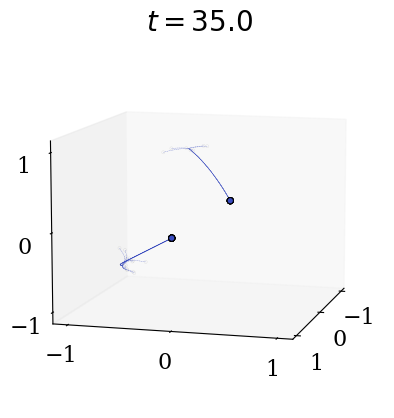

Time 35.00: Cluster Centers:
[[-0.99990294 -0.0056497   0.01273532]
 [ 0.99920355 -0.03251815 -0.02312653]
 [ 0.99920355 -0.03251815 -0.02312653]]
Time 35.00: ARI = 1.0000, NMI = 1.0000, FMI = 1.0000, Silhouette Score = 0.0529, Distance between first two centers = 1.9996


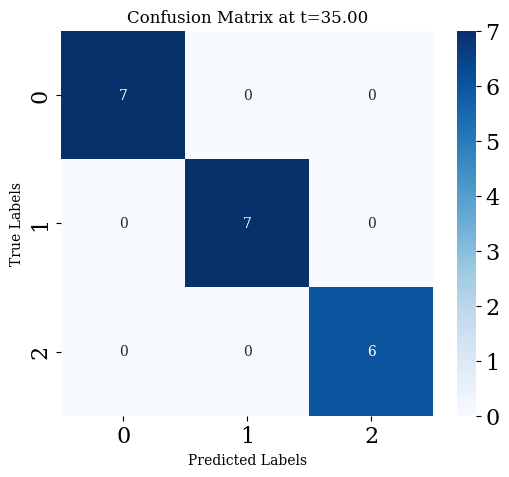

Time 35.00: Loss = -0.05248817882514809
Time 35.10: Loss = -0.053384308215763995
Time 35.20: Loss = -0.05426556613807808
Time 35.30: Loss = -0.055132292768487225
Time 35.40: Loss = -0.05598482085498243
Time 35.50: Loss = -0.056823475869924735
Time 35.60: Loss = -0.05764857616017523
Time 35.70: Loss = -0.05846043309458056
Time 35.80: Loss = -0.05925935120882218
Time 35.90: Loss = -0.06004562834763851
Time 36.00: Loss = -0.06081955580443614
Time 36.10: Loss = -0.061581418458306024
Time 36.20: Loss = -0.06233149490846519
Time 36.30: Loss = -0.06307005760614723
Time 36.40: Loss = -0.06379737298396523
Time 36.50: Loss = -0.06451370158277576
Time 36.60: Loss = -0.06521929817607058
Time 36.70: Loss = -0.06591441189192779
Time 36.80: Loss = -0.06659928633255417
Time 36.90: Loss = -0.06727415969144862
Time 37.00: Loss = -0.06793926486822591
Time 37.10: Loss = -0.06859482958113114
Time 37.20: Loss = -0.06924107647727826
Time 37.30: Loss = -0.06987822324065751
Time 37.40: Loss = -0.07050648269793

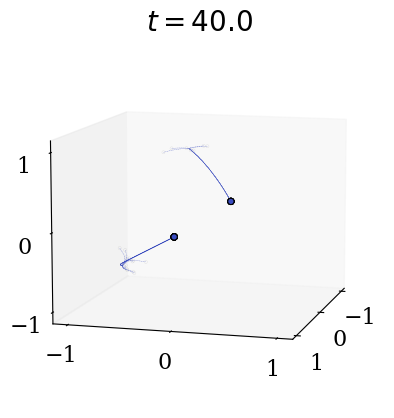

Time 40.00: Cluster Centers:
[[-0.99999321 -0.00150533  0.00336232]
 [ 0.99994375 -0.00866988 -0.00610974]
 [-0.99999321 -0.00150533  0.00336232]]
Time 40.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


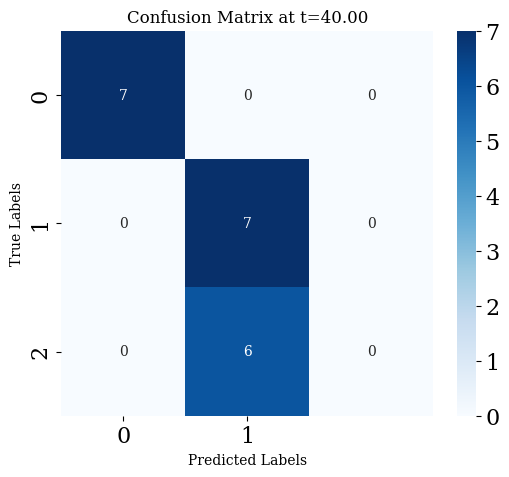

Time 40.00: Loss = -0.08431721986388335
Time 40.10: Loss = -0.08477078094479185
Time 40.20: Loss = -0.08521980951227101
Time 40.30: Loss = -0.08566441497550709
Time 40.40: Loss = -0.08610470421582425
Time 40.50: Loss = -0.08654078164165731
Time 40.60: Loss = -0.08697274924236746
Time 40.70: Loss = -0.08740070664093384
Time 40.80: Loss = -0.08782475114553542
Time 40.90: Loss = -0.08824497780005794
Time 41.00: Loss = -0.08866147943353592
Time 41.10: Loss = -0.08907434670856532
Time 41.20: Loss = -0.08948366816869706
Time 41.30: Loss = -0.08988953028484412
Time 41.40: Loss = -0.09029201750071039
Time 41.50: Loss = -0.09069121227727722
Time 41.60: Loss = -0.09108719513635226
Time 41.70: Loss = -0.09148004470321225
Time 41.80: Loss = -0.09186983774835043
Time 41.90: Loss = -0.09225664922835468
Time 42.00: Loss = -0.09264055232592922
Time 42.10: Loss = -0.09302161848907722
Time 42.20: Loss = -0.09339991746947135
Time 42.30: Loss = -0.09377551736001397
Time 42.40: Loss = -0.09414848463161565


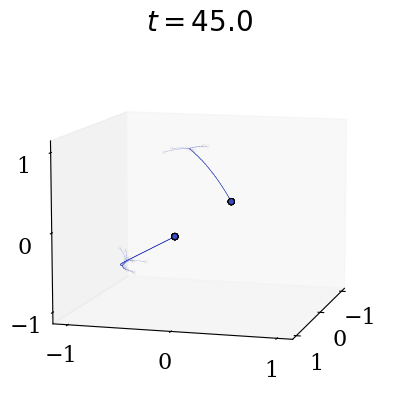

Time 45.00: Cluster Centers:
[[-9.99999627e-01 -3.55440471e-04  7.86846475e-04]
 [ 9.99996882e-01 -2.04724458e-03 -1.42985971e-03]
 [-9.99999627e-01 -3.55440471e-04  7.86846475e-04]]
Time 45.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


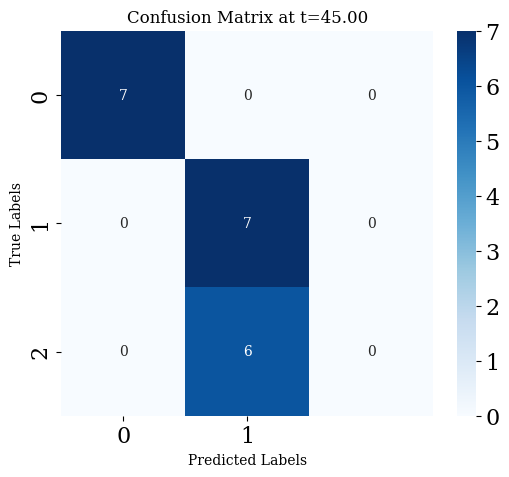

Time 45.00: Loss = -0.1031055335372905
Time 45.10: Loss = -0.1034275074787244
Time 45.20: Loss = -0.10374817905240481
Time 45.30: Loss = -0.10406758068072111
Time 45.40: Loss = -0.1043857439716382
Time 45.50: Loss = -0.10470269973769267
Time 45.60: Loss = -0.1050184780145732
Time 45.70: Loss = -0.10533310807930678
Time 45.80: Loss = -0.10564661846805297
Time 45.90: Loss = -0.10595903699351308
Time 46.00: Loss = -0.10627039076196476
Time 46.10: Loss = -0.10658070618992674
Time 46.20: Loss = -0.10689000902046542
Time 46.30: Loss = -0.1071983243391453
Time 46.40: Loss = -0.10750567658963228
Time 46.50: Loss = -0.10781208958896049
Time 46.60: Loss = -0.10811758654246235
Time 46.70: Loss = -0.10842219005837453
Time 46.80: Loss = -0.10872592216212382
Time 46.90: Loss = -0.10902880431029949
Time 47.00: Loss = -0.10933085740431787
Time 47.10: Loss = -0.10963210180378682
Time 47.20: Loss = -0.10993255733957627
Time 47.30: Loss = -0.1102322433265978
Time 47.40: Loss = -0.11053117857630271
Time 4

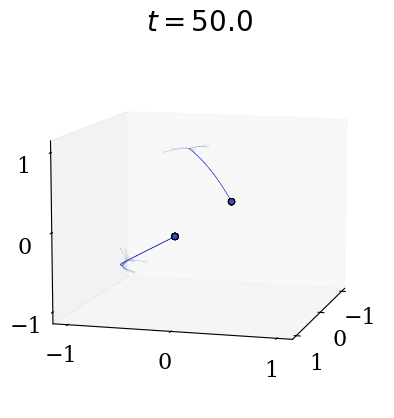

Time 50.00: Cluster Centers:
[[-9.99999984e-01 -7.45647518e-05  1.63603837e-04]
 [ 9.99999864e-01 -4.29474640e-04 -2.97302151e-04]
 [-9.99999984e-01 -7.45647518e-05  1.63603837e-04]]
Time 50.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


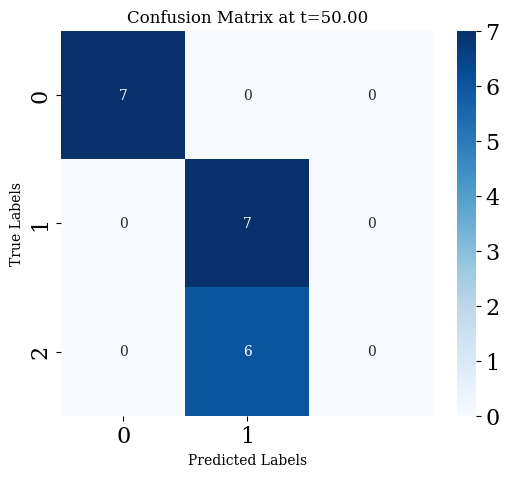

Time 50.00: Loss = -0.11809124555235173
Time 50.10: Loss = -0.11837548120051422
Time 50.20: Loss = -0.11865933131746434
Time 50.30: Loss = -0.11894280446349301
Time 50.40: Loss = -0.11922590896353695
Time 50.50: Loss = -0.11950865291326622
Time 50.60: Loss = -0.11979104418502184
Time 50.70: Loss = -0.12007309043361894
Time 50.80: Loss = -0.12035479910200435
Time 50.90: Loss = -0.1206361774267827
Time 51.00: Loss = -0.12091723244360877
Time 51.10: Loss = -0.1211979709924486
Time 51.20: Loss = -0.1214783997227145
Time 51.30: Loss = -0.12175852509827818
Time 51.40: Loss = -0.12203835340235632
Time 51.50: Loss = -0.1223178907422842
Time 51.60: Loss = -0.12259714305416843
Time 51.70: Loss = -0.12287611610742648
Time 51.80: Loss = -0.1231548155092185
Time 51.90: Loss = -0.12343324670876377
Time 52.00: Loss = -0.12371141500155858
Time 52.10: Loss = -0.12398932553348396
Time 52.20: Loss = -0.12426698330481509
Time 52.30: Loss = -0.12454439317413044
Time 52.40: Loss = -0.12482155986212337
Time 

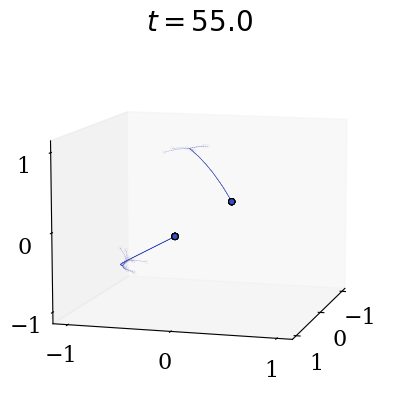

Time 55.00: Cluster Centers:
[[-9.99999999e-01 -1.39193851e-05  3.02706508e-05]
 [ 9.99999995e-01 -8.01722371e-05 -5.50080664e-05]
 [-9.99999999e-01 -1.39193851e-05  3.02706508e-05]]
Time 55.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


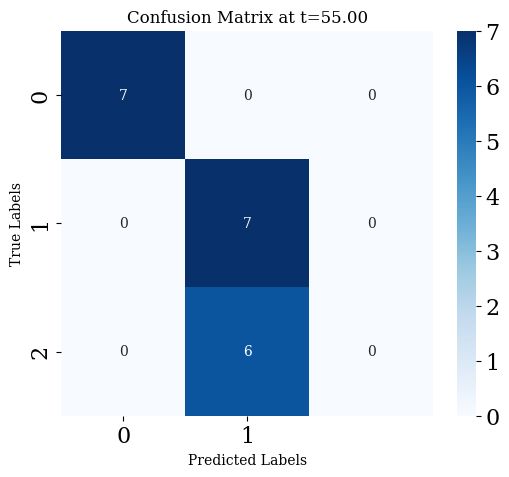

Time 55.00: Loss = -0.13195520584313197
Time 55.10: Loss = -0.1322271770354723
Time 55.20: Loss = -0.13249899406894616
Time 55.30: Loss = -0.1327706589577935
Time 55.40: Loss = -0.13304217365699642
Time 55.50: Loss = -0.13331354006397342
Time 55.60: Loss = -0.13358476002022895
Time 55.70: Loss = -0.13385583531296233
Time 55.80: Loss = -0.13412676767662432
Time 55.90: Loss = -0.13439755879444443
Time 56.00: Loss = -0.1346682102999059
Time 56.10: Loss = -0.1349387237781865
Time 56.20: Loss = -0.13520910076755815
Time 56.30: Loss = -0.13547934276075155
Time 56.40: Loss = -0.13574945120627896
Time 56.50: Loss = -0.13601942750972326
Time 56.60: Loss = -0.1362892730349947
Time 56.70: Loss = -0.13655898910554673
Time 56.80: Loss = -0.13682857700556475
Time 56.90: Loss = -0.13709803798111647
Time 57.00: Loss = -0.13736737324127682
Time 57.10: Loss = -0.13763658395921635
Time 57.20: Loss = -0.13790567127326148
Time 57.30: Loss = -0.13817463628792523
Time 57.40: Loss = -0.1384434800749119
Time 5

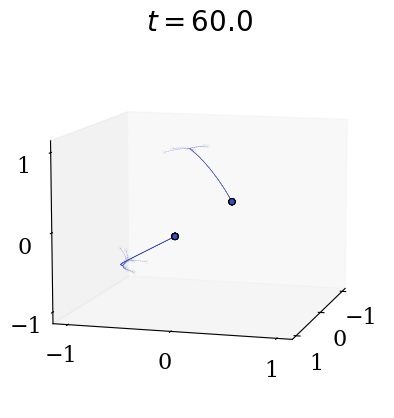

Time 60.00: Cluster Centers:
[[-1.00000000e+00 -2.31528846e-06  4.99056382e-06]
 [ 1.00000000e+00 -1.33354910e-05 -9.06889219e-06]
 [-1.00000000e+00 -2.31528846e-06  4.99056382e-06]]
Time 60.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


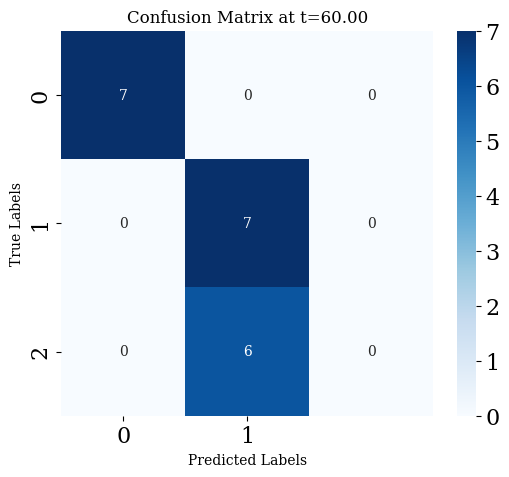

Time 60.00: Loss = -0.14539372323583957
Time 60.10: Loss = -0.1456596022932269
Time 60.20: Loss = -0.14592538010982786
Time 60.30: Loss = -0.14619105713622263
Time 60.40: Loss = -0.14645663381001783
Time 60.50: Loss = -0.14672211055625053
Time 60.60: Loss = -0.14698748778778248
Time 60.70: Loss = -0.14725276590568384
Time 60.80: Loss = -0.14751794529959966
Time 60.90: Loss = -0.14778302634811144
Time 61.00: Loss = -0.14804800941908583
Time 61.10: Loss = -0.14831289487001312
Time 61.20: Loss = -0.14857768304833155
Time 61.30: Loss = -0.14884237429175073
Time 61.40: Loss = -0.14910696892855657
Time 61.50: Loss = -0.149371467277911
Time 61.60: Loss = -0.14963586965014258
Time 61.70: Loss = -0.1499001763470271
Time 61.80: Loss = -0.15016438766206203
Time 61.90: Loss = -0.15042850388072843
Time 62.00: Loss = -0.15069252528074953
Time 62.10: Loss = -0.15095645213233705
Time 62.20: Loss = -0.15122028469843582
Time 62.30: Loss = -0.15148402323495197
Time 62.40: Loss = -0.1517476679909852
Time 

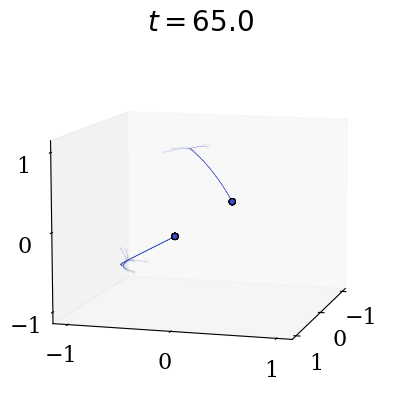

Time 65.00: Cluster Centers:
[[-1.00000000e+00 -3.43583671e-07  7.34040463e-07]
 [ 1.00000000e+00 -1.97895707e-06 -1.33390416e-06]
 [-1.00000000e+00 -3.43583671e-07  7.34040463e-07]]
Time 65.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


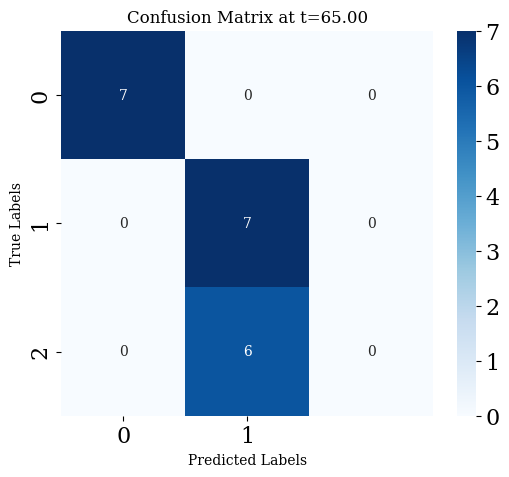

Time 65.00: Loss = -0.1585701966363991
Time 65.10: Loss = -0.15883138375263245
Time 65.20: Loss = -0.15909248202904858
Time 65.30: Loss = -0.15935349158995255
Time 65.40: Loss = -0.15961441255715064
Time 65.50: Loss = -0.15987524505003198
Time 65.60: Loss = -0.16013598918564886
Time 65.70: Loss = -0.16039664507879786
Time 65.80: Loss = -0.16065721284209303
Time 65.90: Loss = -0.16091769258603952
Time 66.00: Loss = -0.16117808441910447
Time 66.10: Loss = -0.16143838844778796
Time 66.20: Loss = -0.16169860477668477
Time 66.30: Loss = -0.16195873350855242
Time 66.40: Loss = -0.1622187747443711
Time 66.50: Loss = -0.16247872858340412
Time 66.60: Loss = -0.16273859512325597
Time 66.70: Loss = -0.16299837445992854
Time 66.80: Loss = -0.16325806668787496
Time 66.90: Loss = -0.16351767190005226
Time 67.00: Loss = -0.16377719018797146
Time 67.10: Loss = -0.16403662164174765
Time 67.20: Loss = -0.16429596635014582
Time 67.30: Loss = -0.16455522440062736
Time 67.40: Loss = -0.16481439587939564
Ti

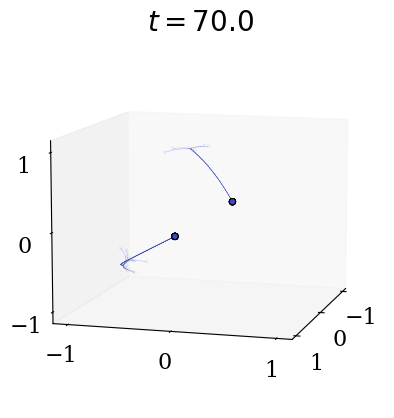

Time 70.00: Cluster Centers:
[[-1.00000000e+00 -4.55437372e-08  9.64404337e-08]
 [ 1.00000000e+00 -2.62320648e-07 -1.75252323e-07]
 [-1.00000000e+00 -4.55437372e-08  9.64404337e-08]]
Time 70.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


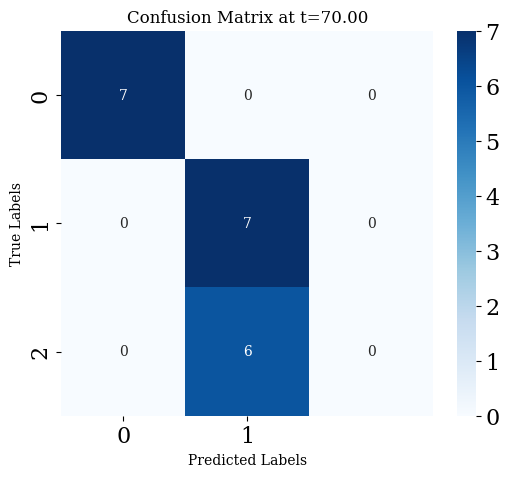

Time 70.00: Loss = -0.17152272546787448
Time 70.10: Loss = -0.17177958848453753
Time 70.20: Loss = -0.17203636697183503
Time 70.30: Loss = -0.1722930609932958
Time 70.40: Loss = -0.17254967061199977
Time 70.50: Loss = -0.17280619589059393
Time 70.60: Loss = -0.1730626368913077
Time 70.70: Loss = -0.17331899367596565
Time 70.80: Loss = -0.17357526630600068
Time 70.90: Loss = -0.17383145484246793
Time 71.00: Loss = -0.1740875593460577
Time 71.10: Loss = -0.1743435798771058
Time 71.20: Loss = -0.17459951649560695
Time 71.30: Loss = -0.17485536926122475
Time 71.40: Loss = -0.17511113823330388
Time 71.50: Loss = -0.17536682347087923
Time 71.60: Loss = -0.17562242503268582
Time 71.70: Loss = -0.17587794297717113
Time 71.80: Loss = -0.17613337736249965
Time 71.90: Loss = -0.1763887282465679
Time 72.00: Loss = -0.17664399568700828
Time 72.10: Loss = -0.17689917974119995
Time 72.20: Loss = -0.17715428046627518
Time 72.30: Loss = -0.17740929791912938
Time 72.40: Loss = -0.17766423215642804
Time 

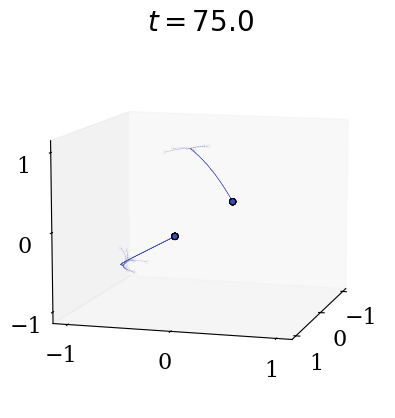

Time 75.00: Cluster Centers:
[[-1.00000000e+00 -5.39891479e-09  1.13313061e-08]
 [ 1.00000000e+00 -3.10964088e-08 -2.05913397e-08]
 [-1.00000000e+00 -5.39891479e-09  1.13313061e-08]]
Time 75.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


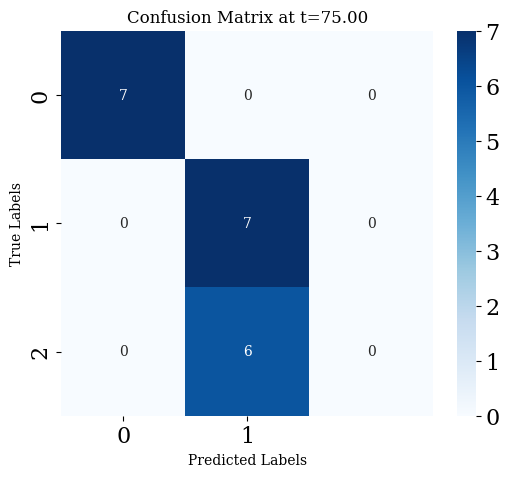

Time 75.00: Loss = -0.18426349472092393
Time 75.10: Loss = -0.1845162028817137
Time 75.20: Loss = -0.18476882934341335
Time 75.30: Loss = -0.18502137415830927
Time 75.40: Loss = -0.18527383737859218
Time 75.50: Loss = -0.18552621905635808
Time 75.60: Loss = -0.18577851924361027
Time 75.70: Loss = -0.18603073799226244
Time 75.80: Loss = -0.186282875354141
Time 75.90: Loss = -0.18653493138098579
Time 76.00: Loss = -0.18678690612445434
Time 76.10: Loss = -0.18703879963611952
Time 76.20: Loss = -0.1872906119674777
Time 76.30: Loss = -0.18754234316994345
Time 76.40: Loss = -0.1877939932948569
Time 76.50: Loss = -0.18804556239348233
Time 76.60: Loss = -0.18829705051700965
Time 76.70: Loss = -0.18854845771655898
Time 76.80: Loss = -0.18879978404317757
Time 76.90: Loss = -0.18905102954784508
Time 77.00: Loss = -0.1893021942814714
Time 77.10: Loss = -0.1895532782949019
Time 77.20: Loss = -0.1898042816389157
Time 77.30: Loss = -0.1900552043642269
Time 77.40: Loss = -0.19030604652148778
Time 77.5

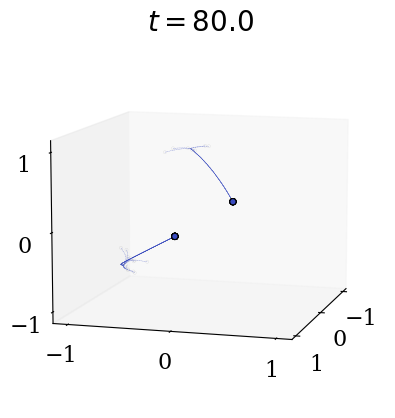

Time 80.00: Cluster Centers:
[[-1.00000000e+00 -5.73015541e-10  1.19201826e-09]
 [ 1.00000000e+00 -3.30042688e-09 -2.16614509e-09]
 [-1.00000000e+00 -5.73015541e-10  1.19201826e-09]]
Time 80.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


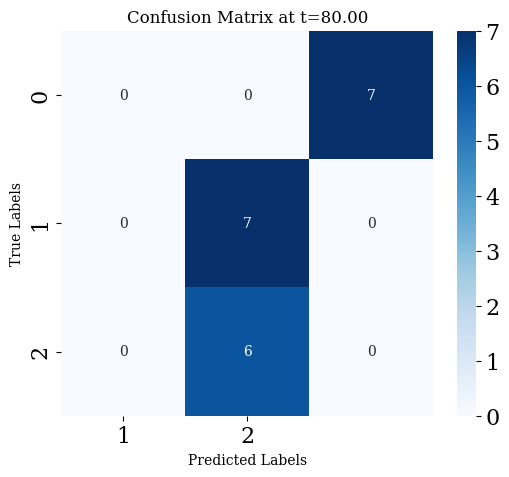

Time 80.00: Loss = -0.19679982779739652
Time 80.10: Loss = -0.19704851355832947
Time 80.20: Loss = -0.19729712014737966
Time 80.30: Loss = -0.19754564761371624
Time 80.40: Loss = -0.1977940960064633
Time 80.50: Loss = -0.19804246537470455
Time 80.60: Loss = -0.19829075576747893
Time 80.70: Loss = -0.19853896723378445
Time 80.80: Loss = -0.19878709982257722
Time 80.90: Loss = -0.19903515358277163
Time 81.00: Loss = -0.1992831285632408
Time 81.10: Loss = -0.1995310248128169
Time 81.20: Loss = -0.1997788423802911
Time 81.30: Loss = -0.2000265813144148
Time 81.40: Loss = -0.200274241663899
Time 81.50: Loss = -0.2005218234774137
Time 81.60: Loss = -0.20076932680359083
Time 81.70: Loss = -0.20101675169102165
Time 81.80: Loss = -0.20126409818825905
Time 81.90: Loss = -0.2015113663438155
Time 82.00: Loss = -0.20175855620616584
Time 82.10: Loss = -0.20200566782374524
Time 82.20: Loss = -0.20225270124495093
Time 82.30: Loss = -0.202499656518142
Time 82.40: Loss = -0.2027465336916383
Time 82.50: 

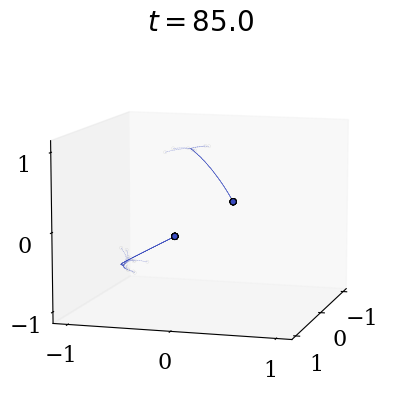

Time 85.00: Cluster Centers:
[[-1.00000000e+00 -5.45126011e-11  1.12397441e-10]
 [ 1.00000000e+00 -3.13978978e-10 -2.04249526e-10]
 [-1.00000000e+00 -5.45126011e-11  1.12397441e-10]]
Time 85.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


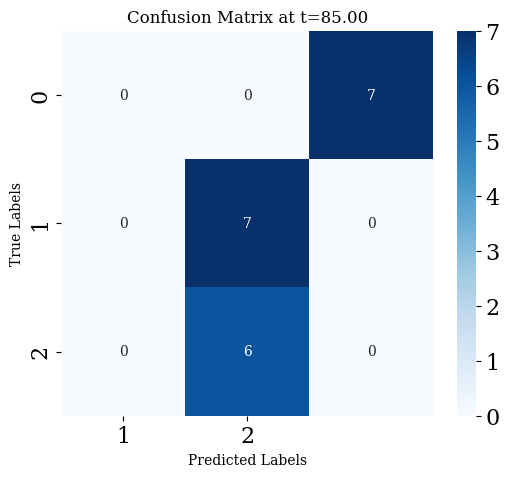

Time 85.00: Loss = -0.20913808462204728
Time 85.10: Loss = -0.20938287123333424
Time 85.20: Loss = -0.20962758108294857
Time 85.30: Loss = -0.20987221421815647
Time 85.40: Loss = -0.210116770686191
Time 85.50: Loss = -0.2103612505342495
Time 85.60: Loss = -0.21060565380949553
Time 85.70: Loss = -0.2108499805590563
Time 85.80: Loss = -0.21109423083002504
Time 85.90: Loss = -0.21133840466946047
Time 86.00: Loss = -0.21158250212438587
Time 86.10: Loss = -0.21182652324179196
Time 86.20: Loss = -0.21207046806863214
Time 86.30: Loss = -0.21231433665182772
Time 86.40: Loss = -0.21255812903826402
Time 86.50: Loss = -0.2128018452747932
Time 86.60: Loss = -0.21304548540823293
Time 86.70: Loss = -0.2132890494853648
Time 86.80: Loss = -0.2135325375529394
Time 86.90: Loss = -0.21377594965767033
Time 87.00: Loss = -0.21401928584623886
Time 87.10: Loss = -0.2142625461652909
Time 87.20: Loss = -0.21450573066143902
Time 87.30: Loss = -0.21474883938126266
Time 87.40: Loss = -0.21499187237130526
Time 87.

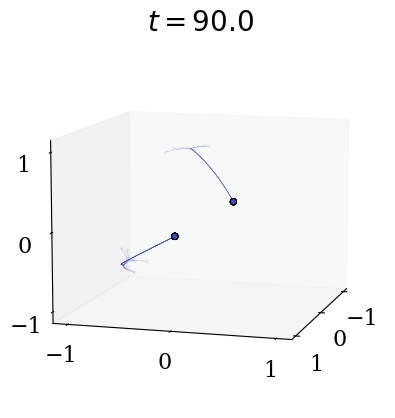

Time 90.00: Cluster Centers:
[[-1.00000000e+00 -4.65344725e-12  9.50993005e-12]
 [ 1.00000000e+00 -2.68026919e-11 -1.72815208e-11]
 [-1.00000000e+00 -4.65344725e-12  9.50993005e-12]]
Time 90.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


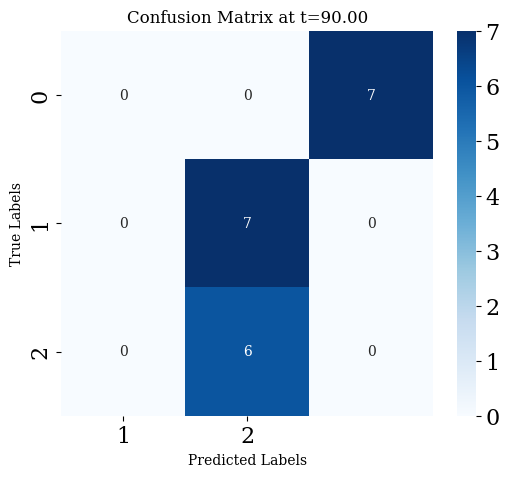

Time 90.00: Loss = -0.22128430063888133
Time 90.10: Loss = -0.22152530639572884
Time 90.20: Loss = -0.22176623771241671
Time 90.30: Loss = -0.2220070946345202
Time 90.40: Loss = -0.22224787720758302
Time 90.50: Loss = -0.2224885854771156
Time 90.60: Loss = -0.2227292194885948
Time 90.70: Loss = -0.22296977928746586
Time 90.80: Loss = -0.2232102649191395
Time 90.90: Loss = -0.22345067642899644
Time 91.00: Loss = -0.22369101386238172
Time 91.10: Loss = -0.22393127726460915
Time 91.20: Loss = -0.22417146668095986
Time 91.30: Loss = -0.2244115821566821
Time 91.40: Loss = -0.2246516237369906
Time 91.50: Loss = -0.22489159146706966
Time 91.60: Loss = -0.22513148539206845
Time 91.70: Loss = -0.22537130555710597
Time 91.80: Loss = -0.2256110520072671
Time 91.90: Loss = -0.22585072478760435
Time 92.00: Loss = -0.22609032394313827
Time 92.10: Loss = -0.22632984951885696
Time 92.20: Loss = -0.22656930155971616
Time 92.30: Loss = -0.2268086801106385
Time 92.40: Loss = -0.22704798521651454
Time 92.

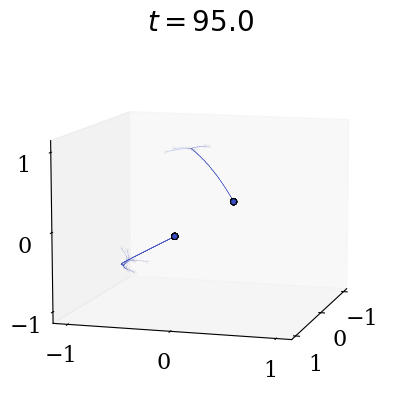

Time 95.00: Cluster Centers:
[[-1.00000000e+00 -3.56833458e-13  7.22788286e-13]
 [ 1.00000000e+00 -2.05527121e-12 -1.31345664e-12]
 [-1.00000000e+00 -3.56833458e-13  7.22788286e-13]]
Time 95.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


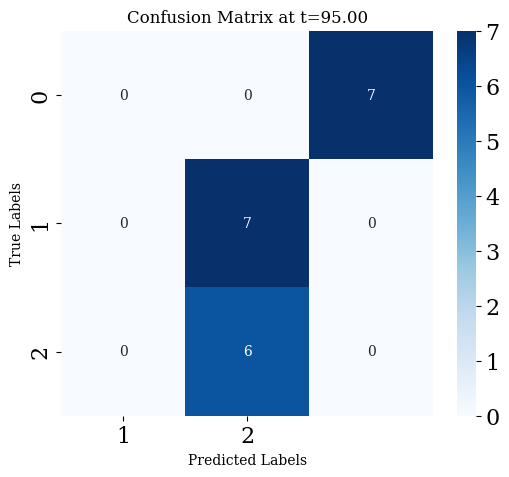

Time 95.00: Loss = -0.23324428505529143
Time 95.10: Loss = -0.23348162399608224
Time 95.20: Loss = -0.23371889073573252
Time 95.30: Loss = -0.23395608531820647
Time 95.40: Loss = -0.23419320778743508
Time 95.50: Loss = -0.23443025818731913
Time 95.60: Loss = -0.2346672365617269
Time 95.70: Loss = -0.23490414295449535
Time 95.80: Loss = -0.2351409774094301
Time 95.90: Loss = -0.23537773997030526
Time 96.00: Loss = -0.23561443068086357
Time 96.10: Loss = -0.23585104958481534
Time 96.20: Loss = -0.23608759672584195
Time 96.30: Loss = -0.23632407214759005
Time 96.40: Loss = -0.23656047589367804
Time 96.50: Loss = -0.23679680800769062
Time 96.60: Loss = -0.23703306853318312
Time 96.70: Loss = -0.23726925751367745
Time 96.80: Loss = -0.2375053749926661
Time 96.90: Loss = -0.23774142101361023
Time 97.00: Loss = -0.23797739561993794
Time 97.10: Loss = -0.23821329885504833
Time 97.20: Loss = -0.23844913076230786
Time 97.30: Loss = -0.23868489138505247
Time 97.40: Loss = -0.23892058076658715
Tim

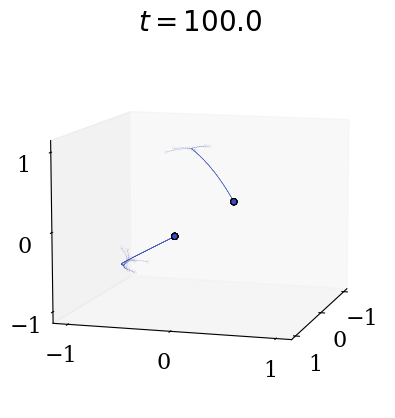

Time 100.00: Cluster Centers:
[[-1.00000000e+00 -2.46050204e-14  4.93983310e-14]
 [ 1.00000000e+00 -1.41718730e-13 -8.97670417e-14]
 [-1.00000000e+00 -2.46050204e-14  4.93983310e-14]]
Time 100.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


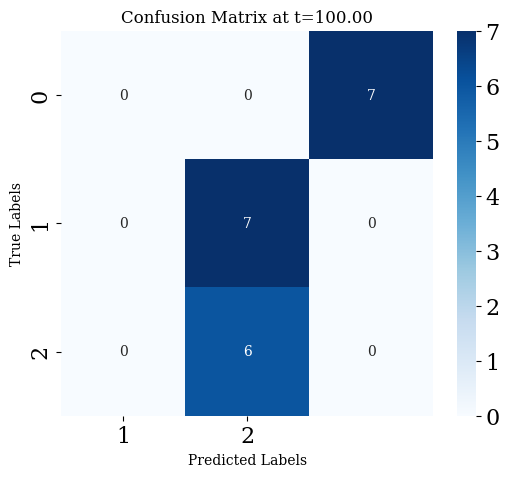

Time 100.00: Loss = -0.24502364015235392
Time 100.10: Loss = -0.24525742227734973
Time 100.20: Loss = -0.24549113436113007
Time 100.30: Loss = -0.24572477644610746
Time 100.40: Loss = -0.24595834857466486
Time 100.50: Loss = -0.24619185078915312
Time 100.60: Loss = -0.2464252831318939
Time 100.70: Loss = -0.24665864564517914
Time 100.80: Loss = -0.24689193837126858
Time 100.90: Loss = -0.24712516135239312
Time 101.00: Loss = -0.24735831463075333
Time 101.10: Loss = -0.24759139824851845
Time 101.20: Loss = -0.24782441224782886
Time 101.30: Loss = -0.24805735667079407
Time 101.40: Loss = -0.24829023155949342
Time 101.50: Loss = -0.2485230369559758
Time 101.60: Loss = -0.24875577290226056
Time 101.70: Loss = -0.24898843944033694
Time 101.80: Loss = -0.24922103661216394
Time 101.90: Loss = -0.24945356445966937
Time 102.00: Loss = -0.2496860230247536
Time 102.10: Loss = -0.24991841234928386
Time 102.20: Loss = -0.2501507324750998
Time 102.30: Loss = -0.2503829834440106
Time 102.40: Loss = -

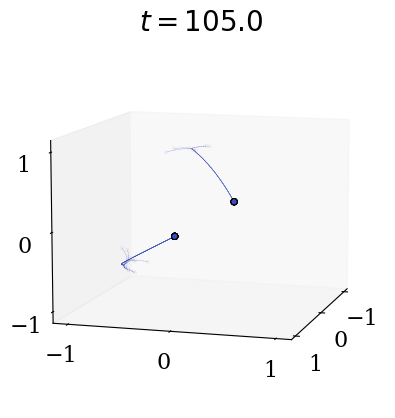

Time 105.00: Cluster Centers:
[[-1.00000000e+00 -1.52719012e-15  3.03895775e-15]
 [ 1.00000000e+00 -8.79623004e-15 -5.52241831e-15]
 [-1.00000000e+00 -1.52719012e-15  3.03895775e-15]]
Time 105.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


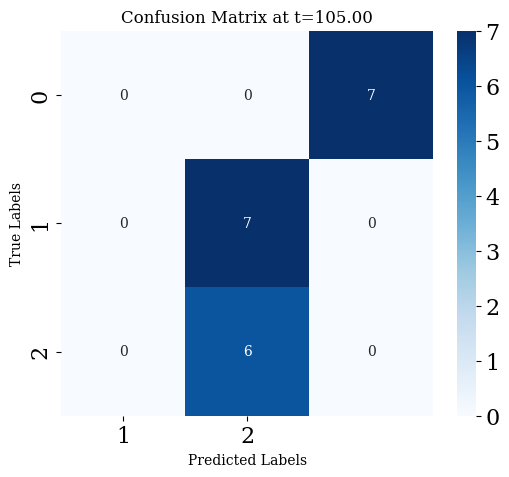

Time 105.00: Loss = -0.25662777024645106
Time 105.10: Loss = -0.25685810167545053
Time 105.20: Loss = -0.25708836514706757
Time 105.30: Loss = -0.25731856070222375
Time 105.40: Loss = -0.2575486883818094
Time 105.50: Loss = -0.25777874822668695
Time 105.60: Loss = -0.2580087402776884
Time 105.70: Loss = -0.2582386645756188
Time 105.80: Loss = -0.2584685211612506
Time 105.90: Loss = -0.2586983100753308
Time 106.00: Loss = -0.2589280313585744
Time 106.10: Loss = -0.25915768505166886
Time 106.20: Loss = -0.2593872711952719
Time 106.30: Loss = -0.2596167898300127
Time 106.40: Loss = -0.2598462409964911
Time 106.50: Loss = -0.26007562473527696
Time 106.60: Loss = -0.26030494108691365
Time 106.70: Loss = -0.26053419009191325
Time 106.80: Loss = -0.26076337179075926
Time 106.90: Loss = -0.26099248622390736
Time 107.00: Loss = -0.2612215334317833
Time 107.10: Loss = -0.2614505134547846
Time 107.20: Loss = -0.26167942633327923
Time 107.30: Loss = -0.2619082721076071
Time 107.40: Loss = -0.26213

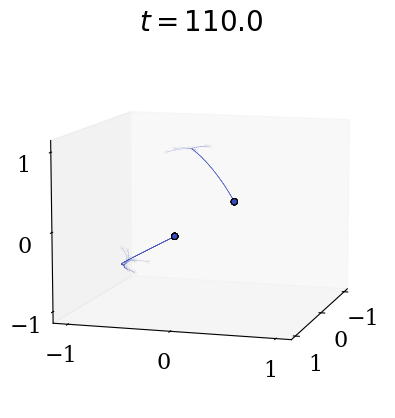

Time 110.00: Cluster Centers:
[[-1.00000000e+00 -8.54096913e-17  1.68454151e-16]
 [ 1.00000000e+00 -4.91938230e-16 -3.06116229e-16]
 [-1.00000000e+00 -8.54096913e-17  1.68454151e-16]]
Time 110.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


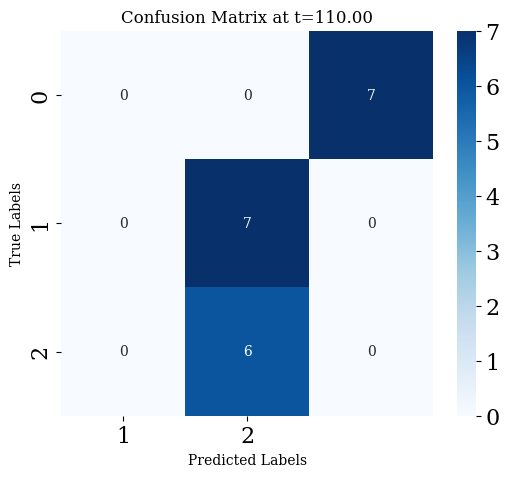

Time 110.00: Loss = -0.2680618892535465
Time 110.10: Loss = -0.2682888723726781
Time 110.20: Loss = -0.26851578954504596
Time 110.30: Loss = -0.2687426408101342
Time 110.40: Loss = -0.2689694262074002
Time 110.50: Loss = -0.2691961457762718
Time 110.60: Loss = -0.26942279955614973
Time 110.70: Loss = -0.26964938758640633
Time 110.80: Loss = -0.26987590990638566
Time 110.90: Loss = -0.2701023665554046
Time 111.00: Loss = -0.2703287575727501
Time 111.10: Loss = -0.270555082997684
Time 111.20: Loss = -0.2707813428694368
Time 111.30: Loss = -0.27100753722721305
Time 111.40: Loss = -0.27123366611019023
Time 111.50: Loss = -0.27145972955751557
Time 111.60: Loss = -0.27168572760831056
Time 111.70: Loss = -0.2719116603016666
Time 111.80: Loss = -0.27213752767664967
Time 111.90: Loss = -0.2723633297722962
Time 112.00: Loss = -0.2725890666276151
Time 112.10: Loss = -0.27281473828158853
Time 112.20: Loss = -0.27304034477316885
Time 112.30: Loss = -0.2732658861412833
Time 112.40: Loss = -0.2734913

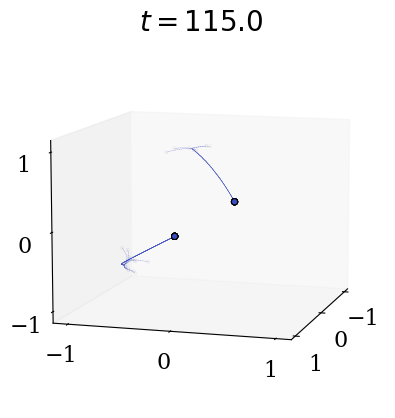

Time 115.00: Cluster Centers:
[[-1.00000000e+00 -4.30813435e-18  8.42183664e-18]
 [ 1.00000000e+00 -2.48137619e-17 -1.53042288e-17]
 [-1.00000000e+00 -4.30813435e-18  8.42183664e-18]]
Time 115.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


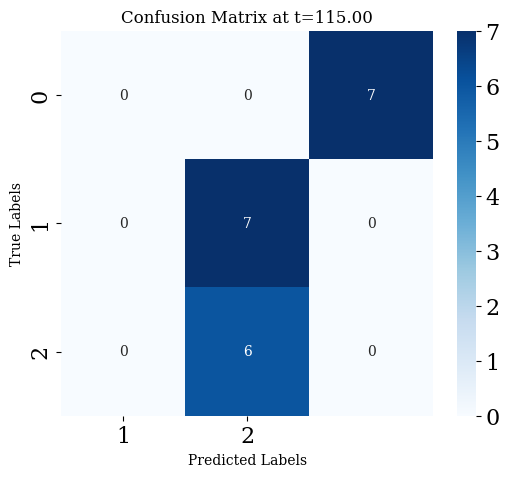

Time 115.00: Loss = -0.27933102788861786
Time 115.10: Loss = -0.27955476149162506
Time 115.20: Loss = -0.27977843108804634
Time 115.30: Loss = -0.28000203671598384
Time 115.40: Loss = -0.2802255784135143
Time 115.50: Loss = -0.28044905621868754
Time 115.60: Loss = -0.28067247016952585
Time 115.70: Loss = -0.2808958203040247
Time 115.80: Loss = -0.2811191066601523
Time 115.90: Loss = -0.2813423292758506
Time 116.00: Loss = -0.2815654881890334
Time 116.10: Loss = -0.2817885834375885
Time 116.20: Loss = -0.28201161505937655
Time 116.30: Loss = -0.2822345830922311
Time 116.40: Loss = -0.2824574875739593
Time 116.50: Loss = -0.2826803285423408
Time 116.60: Loss = -0.2829031060351288
Time 116.70: Loss = -0.2831258200900503
Time 116.80: Loss = -0.28334847074480407
Time 116.90: Loss = -0.2835710580370631
Time 117.00: Loss = -0.2837935820044744
Time 117.10: Loss = -0.28401604268465563
Time 117.20: Loss = -0.28423844011520083
Time 117.30: Loss = -0.2844607743336748
Time 117.40: Loss = -0.2846830

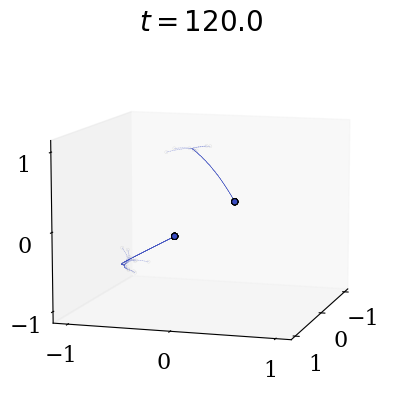

Time 120.00: Cluster Centers:
[[-1.00000000e+00 -1.96179193e-19  3.80113705e-19]
 [ 1.00000000e+00 -1.12994230e-18 -6.90745662e-19]
 [-1.00000000e+00 -1.96179193e-19  3.80113705e-19]]
Time 120.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


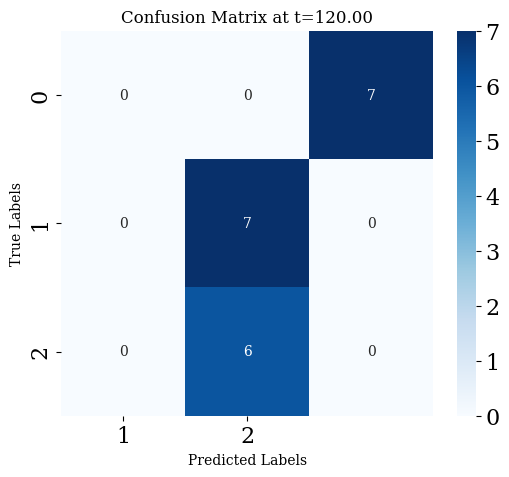

Time 120.00: Loss = -0.29044004060796186
Time 120.10: Loss = -0.29066062003254145
Time 120.20: Loss = -0.290881137322948
Time 120.30: Loss = -0.2911015925159554
Time 120.40: Loss = -0.29132198564831346
Time 120.50: Loss = -0.29154231675674525
Time 120.60: Loss = -0.2917625858779465
Time 120.70: Loss = -0.2919827930485896
Time 120.80: Loss = -0.2922029383053183
Time 120.90: Loss = -0.292423021684752
Time 121.00: Loss = -0.29264304322348417
Time 121.10: Loss = -0.29286300295808115
Time 121.20: Loss = -0.29308290092508477
Time 121.30: Loss = -0.2933027371610105
Time 121.40: Loss = -0.2935225117023467
Time 121.50: Loss = -0.2937422245855587
Time 121.60: Loss = -0.2939618758470839
Time 121.70: Loss = -0.2941814655233336
Time 121.80: Loss = -0.29440099365069494
Time 121.90: Loss = -0.2946204602655282
Time 122.00: Loss = -0.29483986540416873
Time 122.10: Loss = -0.29505920910292477
Time 122.20: Loss = -0.29527849139808093
Time 122.30: Loss = -0.29549771232589417
Time 122.40: Loss = -0.2957168

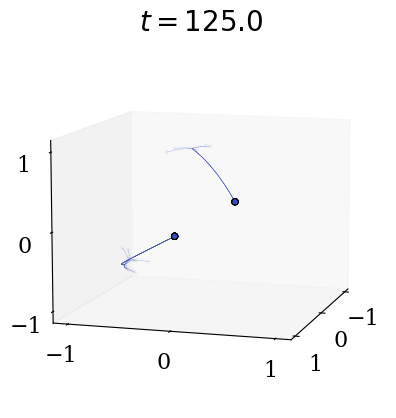

Time 125.00: Cluster Centers:
[[-1.00000000e+00 -8.07239367e-21  1.55026495e-20]
 [ 1.00000000e+00 -4.64949308e-20 -2.81715384e-20]
 [-1.00000000e+00 -8.07239367e-21  1.55026495e-20]]
Time 125.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


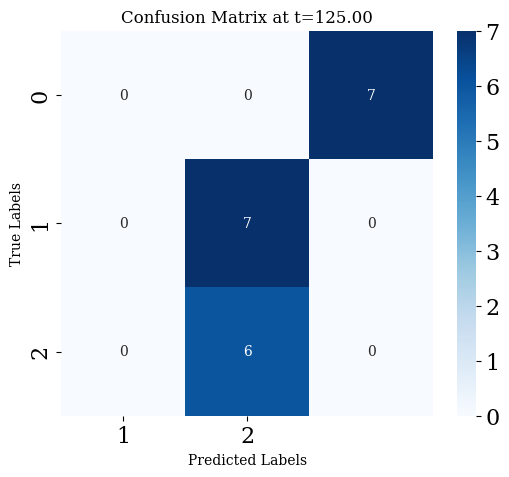

Time 125.00: Loss = -0.30139361230734146
Time 125.10: Loss = -0.3016111295666481
Time 125.20: Loss = -0.30182858649901256
Time 125.30: Loss = -0.3020459831399317
Time 125.40: Loss = -0.3022633195248784
Time 125.50: Loss = -0.3024805956892985
Time 125.60: Loss = -0.3026978116686142
Time 125.70: Loss = -0.30291496749822217
Time 125.80: Loss = -0.30313206321349495
Time 125.90: Loss = -0.3033490988497792
Time 126.00: Loss = -0.30356607444239697
Time 126.10: Loss = -0.30378299002664566
Time 126.20: Loss = -0.30399984563779664
Time 126.30: Loss = -0.3042166413110975
Time 126.40: Loss = -0.3044333770817716
Time 126.50: Loss = -0.3046500529850159
Time 126.60: Loss = -0.3048666690560037
Time 126.70: Loss = -0.30508322532988147
Time 126.80: Loss = -0.3052997218417742
Time 126.90: Loss = -0.3055161586267794
Time 127.00: Loss = -0.30573253571997105
Time 127.10: Loss = -0.3059488531563987
Time 127.20: Loss = -0.3061651109710857
Time 127.30: Loss = -0.3063813091990324
Time 127.40: Loss = -0.30659744

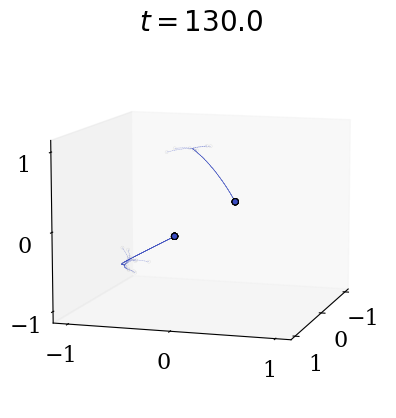

Time 130.00: Cluster Centers:
[[-1.00000000e+00 -3.00422337e-22  5.71845653e-22]
 [ 1.00000000e+00 -1.73035592e-21 -1.03916249e-21]
 [-1.00000000e+00 -3.00422337e-22  5.71845653e-22]]
Time 130.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


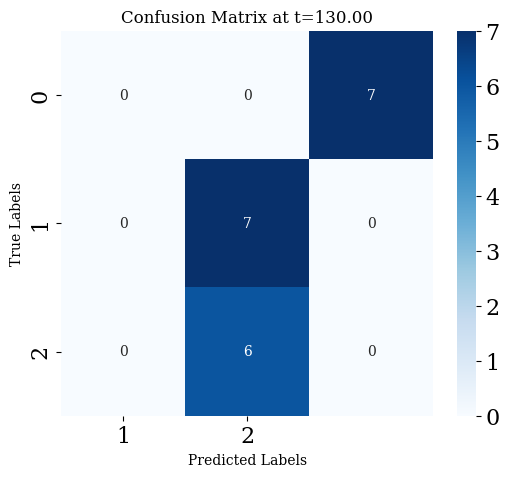

Time 130.00: Loss = -0.312196264780847
Time 130.10: Loss = -0.3124108086902641
Time 130.20: Loss = -0.31262529401727596
Time 130.30: Loss = -0.3128397207961502
Time 130.40: Loss = -0.3130540890611308
Time 130.50: Loss = -0.3132683988464378
Time 130.60: Loss = -0.3134826501862663
Time 130.70: Loss = -0.31369684311478785
Time 130.80: Loss = -0.31391097766615034
Time 130.90: Loss = -0.3141250538744775
Time 131.00: Loss = -0.3143390717738682
Time 131.10: Loss = -0.3145530313983991
Time 131.20: Loss = -0.31476693278212053
Time 131.30: Loss = -0.3149807759590612
Time 131.40: Loss = -0.31519456096322473
Time 131.50: Loss = -0.31540828782859054
Time 131.60: Loss = -0.3156219565891156
Time 131.70: Loss = -0.3158355672787318
Time 131.80: Loss = -0.31604911993134677
Time 131.90: Loss = -0.3162626145808459
Time 132.00: Loss = -0.3164760512610895
Time 132.10: Loss = -0.3166894300059147
Time 132.20: Loss = -0.3169027508491348
Time 132.30: Loss = -0.31711601382453863
Time 132.40: Loss = -0.3173292189

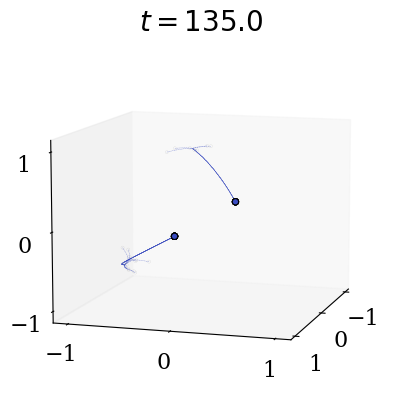

Time 135.00: Cluster Centers:
[[-1.00000000e+00 -1.01211168e-23  1.90949291e-23]
 [ 1.00000000e+00 -5.82950406e-23 -3.46994576e-23]
 [-1.00000000e+00 -1.01211168e-23  1.90949291e-23]]
Time 135.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


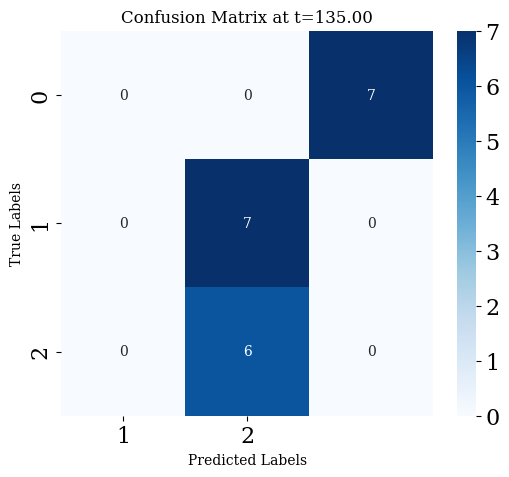

Time 135.00: Loss = -0.3228523629452511
Time 135.10: Loss = -0.3230640192445195
Time 135.20: Loss = -0.323275618645621
Time 135.30: Loss = -0.32348716118164117
Time 135.40: Loss = -0.3236986468856431
Time 135.50: Loss = -0.32391007579066555
Time 135.60: Loss = -0.32412144792972497
Time 135.70: Loss = -0.32433276333581446
Time 135.80: Loss = -0.3245440220419048
Time 135.90: Loss = -0.3247552240809416
Time 136.00: Loss = -0.32496636948584934
Time 136.10: Loss = -0.3251774582895293
Time 136.20: Loss = -0.325388490524859
Time 136.30: Loss = -0.32559946622469305
Time 136.40: Loss = -0.3258103854218627
Time 136.50: Loss = -0.3260212481491777
Time 136.60: Loss = -0.32623205443942316
Time 136.70: Loss = -0.32644280432536255
Time 136.80: Loss = -0.3266534978397353
Time 136.90: Loss = -0.32686413501525907
Time 137.00: Loss = -0.32707471588462717
Time 137.10: Loss = -0.3272852404805119
Time 137.20: Loss = -0.32749570883556084
Time 137.30: Loss = -0.32770612098240026
Time 137.40: Loss = -0.3279164

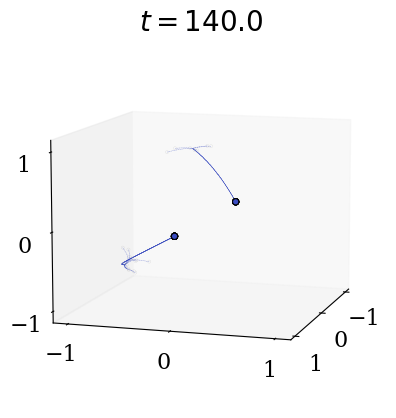

Time 140.00: Cluster Centers:
[[-1.00000000e+00 -3.08935686e-25  5.77697783e-25]
 [ 1.00000000e+00 -1.77939022e-24 -1.04979702e-24]
 [-1.00000000e+00 -3.08935686e-25  5.77697783e-25]]
Time 140.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


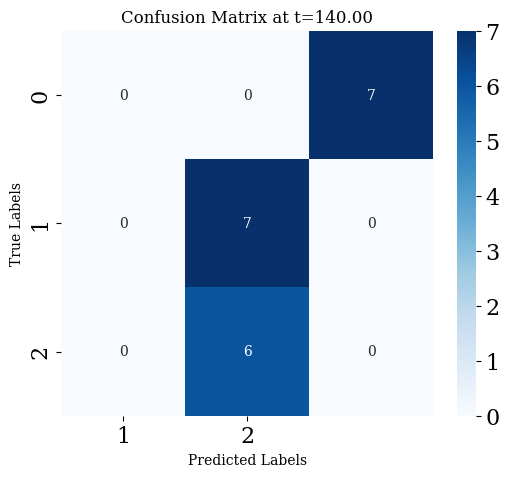

Time 140.00: Loss = -0.333366120835013
Time 140.10: Loss = -0.3335749723058291
Time 140.20: Loss = -0.3337837685047248
Time 140.30: Loss = -0.33399250946364933
Time 140.40: Loss = -0.33420119521452873
Time 140.50: Loss = -0.3344098257892675
Time 140.60: Loss = -0.33461840121974756
Time 140.70: Loss = -0.33482692153782845
Time 140.80: Loss = -0.3350353867753482
Time 140.90: Loss = -0.33524379696412143
Time 141.00: Loss = -0.3354521521359418
Time 141.10: Loss = -0.33566045232258046
Time 141.20: Loss = -0.3358686975557858
Time 141.30: Loss = -0.33607688786728457
Time 141.40: Loss = -0.33628502328878124
Time 141.50: Loss = -0.33649310385195863
Time 141.60: Loss = -0.33670112958847676
Time 141.70: Loss = -0.33690910052997414
Time 141.80: Loss = -0.3371170167080676
Time 141.90: Loss = -0.33732487815435075
Time 142.00: Loss = -0.33753268490039545
Time 142.10: Loss = -0.33774043697775297
Time 142.20: Loss = -0.33794813441795085
Time 142.30: Loss = -0.3381557772524958
Time 142.40: Loss = -0.338

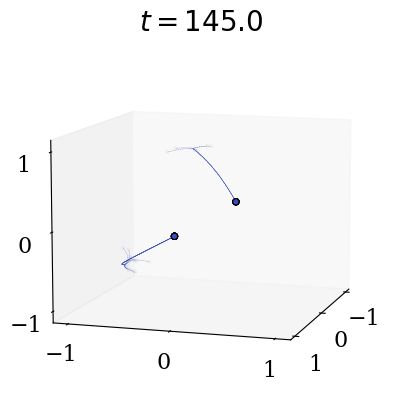

Time 145.00: Cluster Centers:
[[-1.00000000e+00 -8.55105605e-27  1.58487635e-26]
 [ 1.00000000e+00 -4.92518813e-26 -2.88004995e-26]
 [-1.00000000e+00 -8.55105605e-27  1.58487635e-26]]
Time 145.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


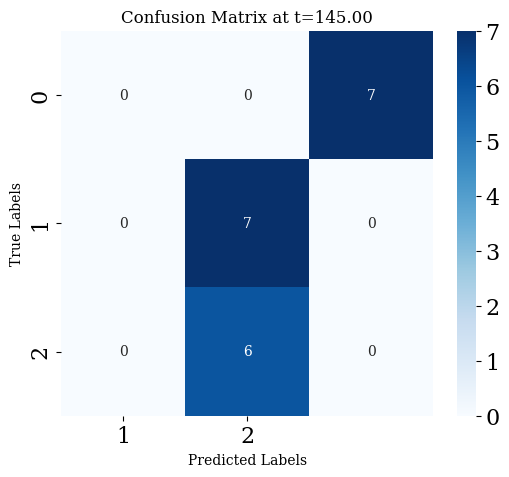

Time 145.00: Loss = -0.34374160737348225
Time 145.10: Loss = -0.3439477339526805
Time 145.20: Loss = -0.34415380683043284
Time 145.30: Loss = -0.34435982603759385
Time 145.40: Loss = -0.344565791604998
Time 145.50: Loss = -0.34477170356345804
Time 145.60: Loss = -0.3449775619437646
Time 145.70: Loss = -0.3451833667766884
Time 145.80: Loss = -0.3453891180929761
Time 145.90: Loss = -0.3455948159233564
Time 146.00: Loss = -0.3458004602985338
Time 146.10: Loss = -0.34600605124919415
Time 146.20: Loss = -0.346211588805999
Time 146.30: Loss = -0.34641707299959046
Time 146.40: Loss = -0.34662250386058985
Time 146.50: Loss = -0.346827881419596
Time 146.60: Loss = -0.34703320570718693
Time 146.70: Loss = -0.347238476753919
Time 146.80: Loss = -0.34744369459032864
Time 146.90: Loss = -0.3476488592469296
Time 147.00: Loss = -0.3478539707542156
Time 147.10: Loss = -0.3480590291426589
Time 147.20: Loss = -0.3482640344427099
Time 147.30: Loss = -0.3484689866847982
Time 147.40: Loss = -0.348673885899

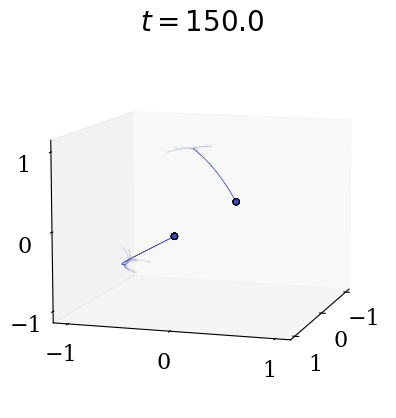

Time 150.00: Cluster Centers:
[[-1.00000000e+00 -2.14804721e-28  3.94604891e-28]
 [ 1.00000000e+00 -1.23721974e-27 -7.17079152e-28]
 [-1.00000000e+00 -2.14804721e-28  3.94604891e-28]]
Time 150.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


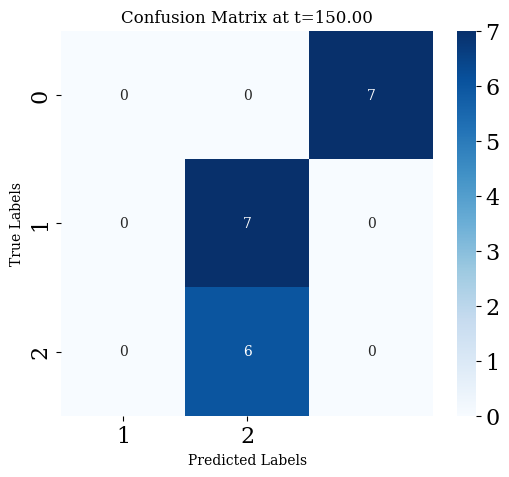

Time 150.00: Loss = -0.35398275192615036
Time 150.10: Loss = -0.3541862308145852
Time 150.20: Loss = -0.35438965751840973
Time 150.30: Loss = -0.3545930320674279
Time 150.40: Loss = -0.35479635449142355
Time 150.50: Loss = -0.35499962482015823
Time 150.60: Loss = -0.35520284308337496
Time 150.70: Loss = -0.3554060093107943
Time 150.80: Loss = -0.3556091235321177
Time 150.90: Loss = -0.35581218577702567
Time 151.00: Loss = -0.35601519607517784
Time 151.10: Loss = -0.3562181544562142
Time 151.20: Loss = -0.35642106094975234
Time 151.30: Loss = -0.35662391558539197
Time 151.40: Loss = -0.3568267183927101
Time 151.50: Loss = -0.3570294694012646
Time 151.60: Loss = -0.3572321686405934
Time 151.70: Loss = -0.3574348161402117
Time 151.80: Loss = -0.35763741192961734
Time 151.90: Loss = -0.3578399560382845
Time 152.00: Loss = -0.35804244849567
Time 152.10: Loss = -0.3582448893312091
Time 152.20: Loss = -0.35844727857431574
Time 152.30: Loss = -0.35864961625438596
Time 152.40: Loss = -0.3588519

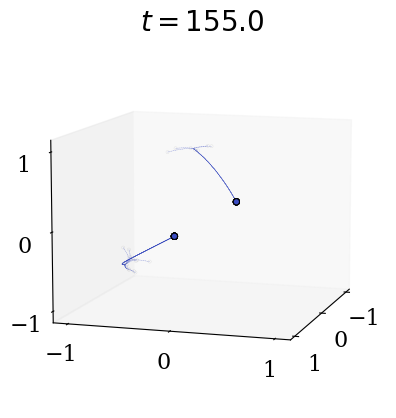

Time 155.00: Cluster Centers:
[[-1.00000000e+00 -4.90108940e-30  8.92389139e-30]
 [ 1.00000000e+00 -2.82290065e-29 -1.62165665e-29]
 [-1.00000000e+00 -4.90108940e-30  8.92389139e-30]]
Time 155.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


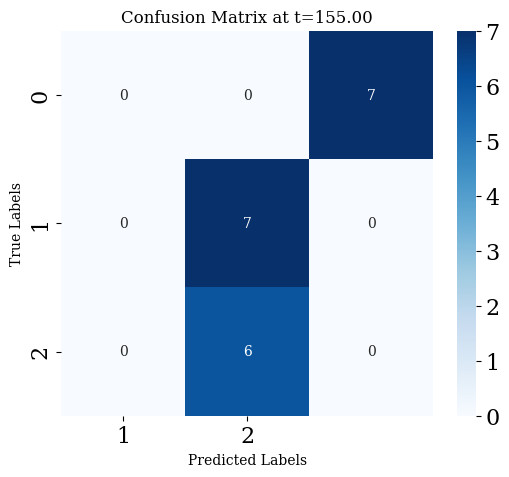

Time 155.00: Loss = -0.3640933496419924
Time 155.10: Loss = -0.364294255409246
Time 155.20: Loss = -0.3644951104571403
Time 155.30: Loss = -0.3646959148144678
Time 155.40: Loss = -0.3648966685100009
Time 155.50: Loss = -0.365097371572492
Time 155.60: Loss = -0.36529802403067557
Time 155.70: Loss = -0.3654986259132637
Time 155.80: Loss = -0.36569917724895057
Time 155.90: Loss = -0.36589967806641027
Time 156.00: Loss = -0.366100128394296
Time 156.10: Loss = -0.366300528261242
Time 156.20: Loss = -0.3665008776958639
Time 156.30: Loss = -0.366701176726756
Time 156.40: Loss = -0.36690142538249343
Time 156.50: Loss = -0.3671016236916326
Time 156.60: Loss = -0.36730177168270856
Time 156.70: Loss = -0.3675018693842385
Time 156.80: Loss = -0.3677019168247185
Time 156.90: Loss = -0.3679019140326255
Time 157.00: Loss = -0.36810186103641773
Time 157.10: Loss = -0.36830175786453256
Time 157.20: Loss = -0.368501604545389
Time 157.30: Loss = -0.36870140110738625
Time 157.40: Loss = -0.368901147578902

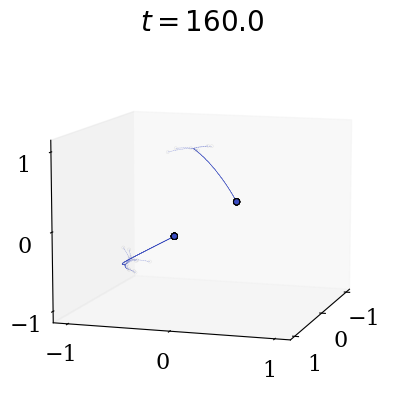

Time 160.00: Cluster Centers:
[[-1.00000000e+00 -1.01650778e-31  1.83449008e-31]
 [ 1.00000000e+00 -5.85482102e-31 -3.33364996e-31]
 [-1.00000000e+00 -1.01650778e-31  1.83449008e-31]]
Time 160.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


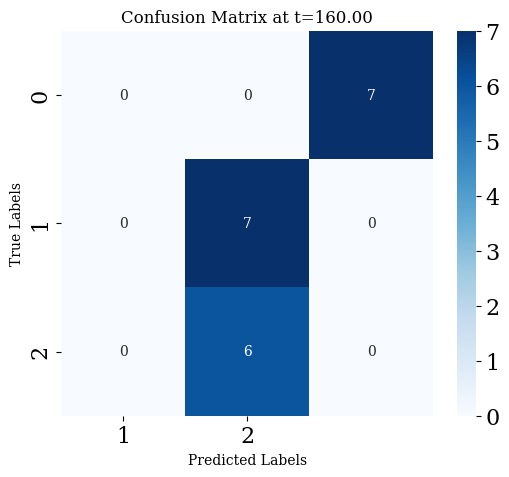

Time 160.00: Loss = -0.3740770665891192
Time 160.10: Loss = -0.37427547127416105
Time 160.20: Loss = -0.3744738266554809
Time 160.30: Loss = -0.3746721327608986
Time 160.40: Loss = -0.37487038961821606
Time 160.50: Loss = -0.37506859725521435
Time 160.60: Loss = -0.3752667556996562
Time 160.70: Loss = -0.375464864979285
Time 160.80: Loss = -0.3756629251218256
Time 160.90: Loss = -0.3758609361549842
Time 161.00: Loss = -0.3760588981064465
Time 161.10: Loss = -0.3762568110038808
Time 161.20: Loss = -0.37645467487493606
Time 161.30: Loss = -0.376652489747242
Time 161.40: Loss = -0.3768502556484086
Time 161.50: Loss = -0.37704797260602907
Time 161.60: Loss = -0.37724564064767624
Time 161.70: Loss = -0.3774432598009041
Time 161.80: Loss = -0.37764083009324784
Time 161.90: Loss = -0.37783835155222467
Time 162.00: Loss = -0.3780358242053314
Time 162.10: Loss = -0.37823324808004777
Time 162.20: Loss = -0.3784306232038332
Time 162.30: Loss = -0.3786279496041288
Time 162.40: Loss = -0.3788252273

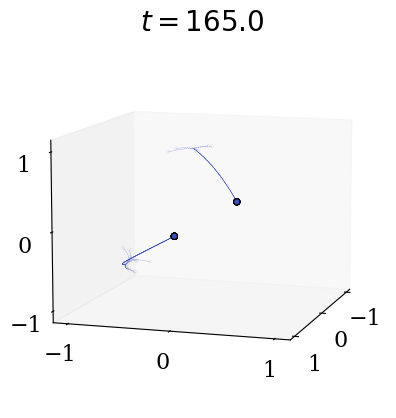

Time 165.00: Cluster Centers:
[[-1.00000000e+00 -1.91794006e-33  3.43069968e-33]
 [ 1.00000000e+00 -1.10468358e-32 -6.23429472e-33]
 [-1.00000000e+00 -1.91794006e-33  3.43069968e-33]]
Time 165.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


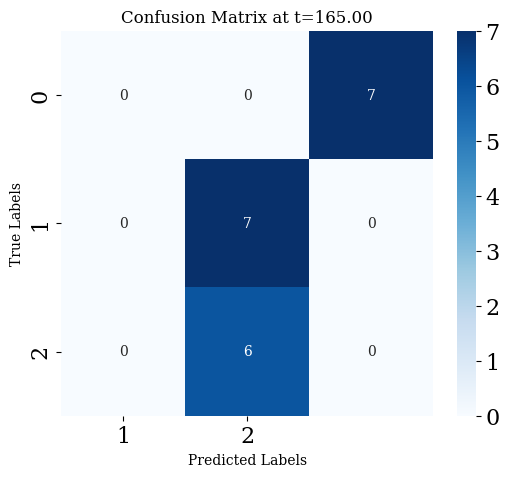

Time 165.00: Loss = -0.3839374446910536
Time 165.10: Loss = -0.3841334178989733
Time 165.20: Loss = -0.38432934317109185
Time 165.30: Loss = -0.3845252205342946
Time 165.40: Loss = -0.38472105001544693
Time 165.50: Loss = -0.38491683164139595
Time 165.60: Loss = -0.3851125654389721
Time 165.70: Loss = -0.38530825143498576
Time 165.80: Loss = -0.3855038896562304
Time 165.90: Loss = -0.38569948012947897
Time 166.00: Loss = -0.38589502288149
Time 166.10: Loss = -0.38609051793899957
Time 166.20: Loss = -0.38628596532872816
Time 166.30: Loss = -0.38648136507737696
Time 166.40: Loss = -0.3866767172116299
Time 166.50: Loss = -0.3868720217581517
Time 166.60: Loss = -0.3870672787435895
Time 166.70: Loss = -0.3872624881945729
Time 166.80: Loss = -0.38745765013771105
Time 166.90: Loss = -0.3876527645995973
Time 167.00: Loss = -0.3878478316068068
Time 167.10: Loss = -0.3880428511858944
Time 167.20: Loss = -0.38823782336339974
Time 167.30: Loss = -0.38843274816584206
Time 167.40: Loss = -0.38862762

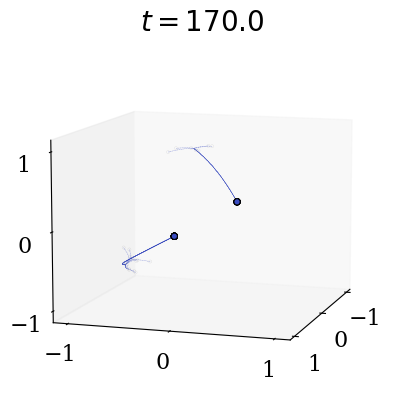

Time 170.00: Cluster Centers:
[[-1.00000000e+00 -3.29454313e-35  5.84098214e-35]
 [ 1.00000000e+00 -1.89757090e-34 -1.06142791e-34]
 [-1.00000000e+00 -3.29454313e-35  5.84098214e-35]]
Time 170.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


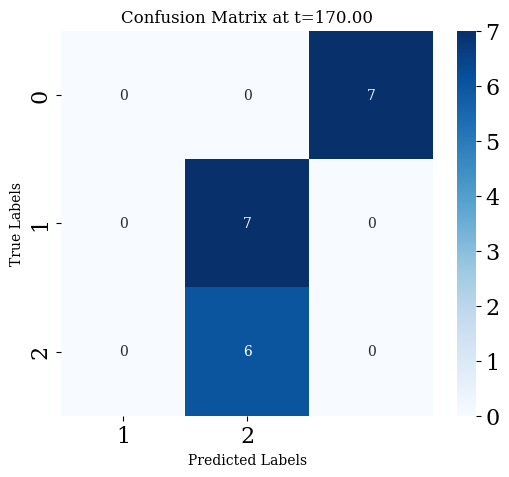

Time 170.00: Loss = -0.3936779064699912
Time 170.10: Loss = -0.3938715154649416
Time 170.20: Loss = -0.3940650778461165
Time 170.30: Loss = -0.39425859363949944
Time 170.40: Loss = -0.3944520628710584
Time 170.50: Loss = -0.39464548556674095
Time 170.60: Loss = -0.39483886175247995
Time 170.70: Loss = -0.3950321914541895
Time 170.80: Loss = -0.3952254746977652
Time 170.90: Loss = -0.3954187115090864
Time 171.00: Loss = -0.39561190191401396
Time 171.10: Loss = -0.39580504593839205
Time 171.20: Loss = -0.39599814360804697
Time 171.30: Loss = -0.3961911949487864
Time 171.40: Loss = -0.3963841999864021
Time 171.50: Loss = -0.3965771587466683
Time 171.60: Loss = -0.3967700712553407
Time 171.70: Loss = -0.396962937538158
Time 171.80: Loss = -0.397155757620841
Time 171.90: Loss = -0.39734853152909466
Time 172.00: Loss = -0.3975412592886046
Time 172.10: Loss = -0.39773394092503966
Time 172.20: Loss = -0.3979265764640523
Time 172.30: Loss = -0.39811916593127533
Time 172.40: Loss = -0.3983117093

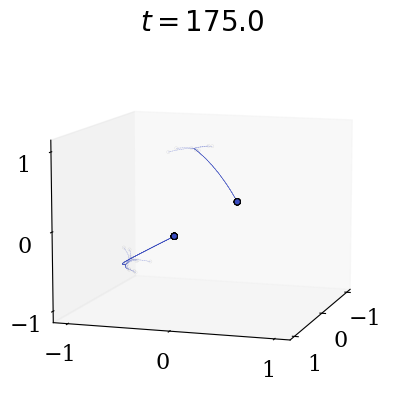

Time 175.00: Cluster Centers:
[[-1.00000000e+00 -5.15600865e-37  9.06039907e-37]
 [ 1.00000000e+00 -2.96972613e-36 -1.64646290e-36]
 [-1.00000000e+00 -5.15600865e-37  9.06039907e-37]]
Time 175.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


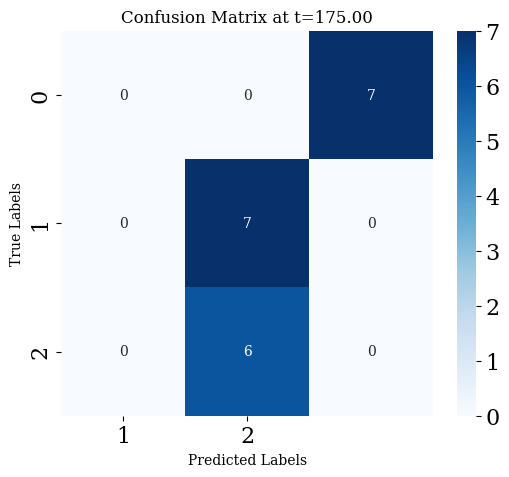

Time 175.00: Loss = -0.4033017596034368
Time 175.10: Loss = -0.4034930693979071
Time 175.20: Loss = -0.40368433385647845
Time 175.30: Loss = -0.40387555300427025
Time 175.40: Loss = -0.4040667268663837
Time 175.50: Loss = -0.40425785546790494
Time 175.60: Loss = -0.4044489388339014
Time 175.70: Loss = -0.4046399769894241
Time 175.80: Loss = -0.4048309699595066
Time 175.90: Loss = -0.40502191776916757
Time 176.00: Loss = -0.4052128204434064
Time 176.10: Loss = -0.40540367800720684
Time 176.20: Loss = -0.40559449048553525
Time 176.30: Loss = -0.40578525790334163
Time 176.40: Loss = -0.40597598028555854
Time 176.50: Loss = -0.4061666576571031
Time 176.60: Loss = -0.40635729004287313
Time 176.70: Loss = -0.406547877467753
Time 176.80: Loss = -0.40673841995660664
Time 176.90: Loss = -0.40692891753428356
Time 177.00: Loss = -0.40711937022561634
Time 177.10: Loss = -0.4073097780554198
Time 177.20: Loss = -0.40750014104849264
Time 177.30: Loss = -0.4076904592296174
Time 177.40: Loss = -0.40788

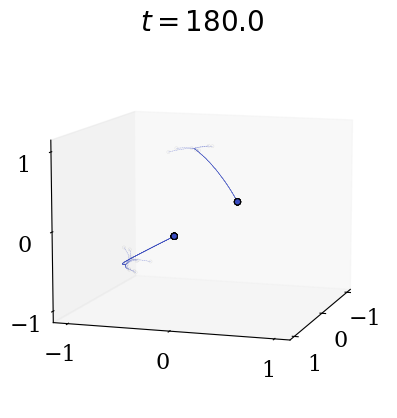

Time 180.00: Cluster Centers:
[[-1.00000000e+00 -7.35708566e-39  1.28139349e-38]
 [ 1.00000000e+00 -4.23748841e-38 -2.32855839e-38]
 [-1.00000000e+00 -7.35708566e-39  1.28139349e-38]]
Time 180.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


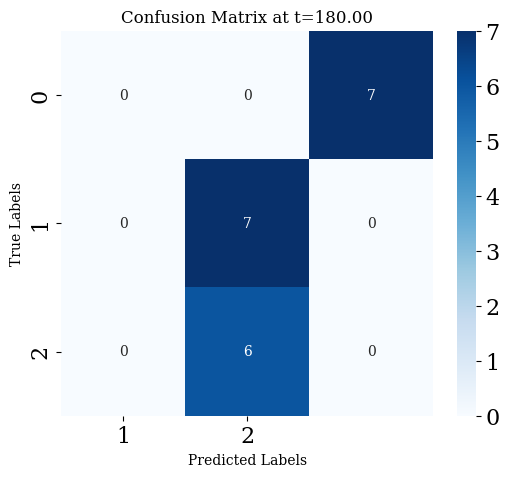

Time 180.00: Loss = -0.41281220130056406
Time 180.10: Loss = -0.41300127474110787
Time 180.20: Loss = -0.4131903040811632
Time 180.30: Loss = -0.4133792893450151
Time 180.40: Loss = -0.41356823055693415
Time 180.50: Loss = -0.41375712774117435
Time 180.60: Loss = -0.4139459809219715
Time 180.70: Loss = -0.41413479012354804
Time 180.80: Loss = -0.41432355537010757
Time 180.90: Loss = -0.4145122766858392
Time 181.00: Loss = -0.41470095409491503
Time 181.10: Loss = -0.41488958762149125
Time 181.20: Loss = -0.41507817728970703
Time 181.30: Loss = -0.4152667231236856
Time 181.40: Loss = -0.41545522514753497
Time 181.50: Loss = -0.4156436833853462
Time 181.60: Loss = -0.41583209786119346
Time 181.70: Loss = -0.41602046859913616
Time 181.80: Loss = -0.4162087956232169
Time 181.90: Loss = -0.41639707895746236
Time 182.00: Loss = -0.41658531862588194
Time 182.10: Loss = -0.41677351465247126
Time 182.20: Loss = -0.41696166706120763
Time 182.30: Loss = -0.4171497758760525
Time 182.40: Loss = -0.4

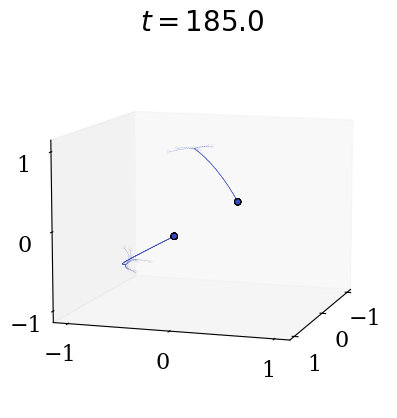

Time 185.00: Cluster Centers:
[[-1.00000000e+00 -9.57812301e-41  1.65348446e-40]
 [ 1.00000000e+00 -5.51674701e-40 -3.00472504e-40]
 [-1.00000000e+00 -9.57812301e-41  1.65348446e-40]]
Time 185.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


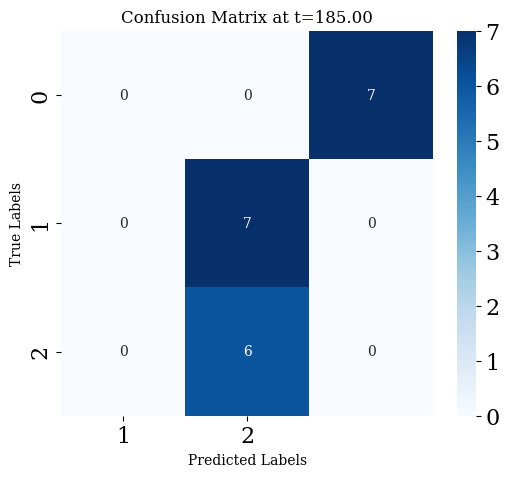

Time 185.00: Loss = -0.422212322504601
Time 185.10: Loss = -0.42239922035415667
Time 185.20: Loss = -0.42258607529777753
Time 185.30: Loss = -0.4227728873589488
Time 185.40: Loss = -0.42295965656113904
Time 185.50: Loss = -0.42314638292780293
Time 185.60: Loss = -0.4233330664823777
Time 185.70: Loss = -0.42351970724828547
Time 185.80: Loss = -0.42370630524893355
Time 185.90: Loss = -0.42389286050771335
Time 186.00: Loss = -0.42407937304799903
Time 186.10: Loss = -0.4242658428931512
Time 186.20: Loss = -0.4244522700665138
Time 186.30: Loss = -0.42463865459141503
Time 186.40: Loss = -0.4248249964911682
Time 186.50: Loss = -0.42501129578907076
Time 186.60: Loss = -0.42519755250840474
Time 186.70: Loss = -0.42538376667243627
Time 186.80: Loss = -0.4255699383044155
Time 186.90: Loss = -0.4257560674275777
Time 187.00: Loss = -0.42594215406514335
Time 187.10: Loss = -0.4261281982403159
Time 187.20: Loss = -0.42631419997628467
Time 187.30: Loss = -0.426500159296222
Time 187.40: Loss = -0.42668

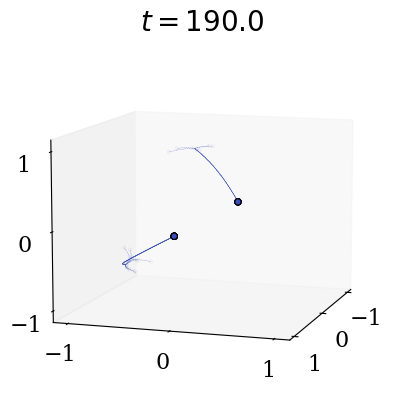

Time 190.00: Cluster Centers:
[[-1.00000000e+00 -1.13851701e-42  1.94805961e-42]
 [ 1.00000000e+00 -6.55755782e-42 -3.54002930e-42]
 [-1.00000000e+00 -1.13851701e-42  1.94805961e-42]]
Time 190.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


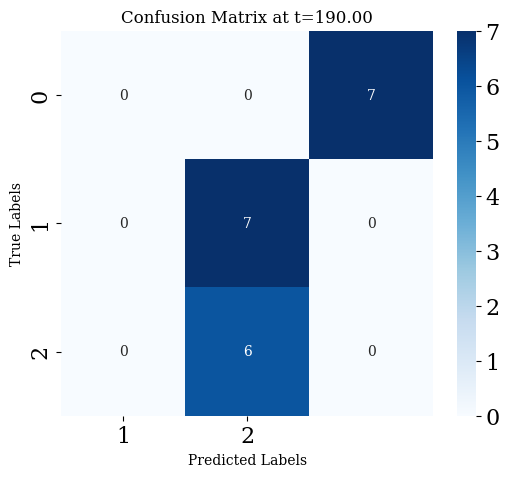

Time 190.00: Loss = -0.4315051119274866
Time 190.10: Loss = -0.4316898929443994
Time 190.20: Loss = -0.43187463221062394
Time 190.30: Loss = -0.43205932974887434
Time 190.40: Loss = -0.43224398558184934
Time 190.50: Loss = -0.43242859973223274
Time 190.60: Loss = -0.4326131722226939
Time 190.70: Loss = -0.4327977030758864
Time 190.80: Loss = -0.43298219231444995
Time 190.90: Loss = -0.4331666399610074
Time 191.00: Loss = -0.4333510460381677
Time 191.10: Loss = -0.4335354105685247
Time 191.20: Loss = -0.4337197335746571
Time 191.30: Loss = -0.43390401507912835
Time 191.40: Loss = -0.4340882551044879
Time 191.50: Loss = -0.43427245367326767
Time 191.60: Loss = -0.43445661080798825
Time 191.70: Loss = -0.4346407265311522
Time 191.80: Loss = -0.43482480086524855
Time 191.90: Loss = -0.4350088338327519
Time 192.00: Loss = -0.4351928254561197
Time 192.10: Loss = -0.43537677575779715
Time 192.20: Loss = -0.4355606847602128
Time 192.30: Loss = -0.4357445524857808
Time 192.40: Loss = -0.4359283

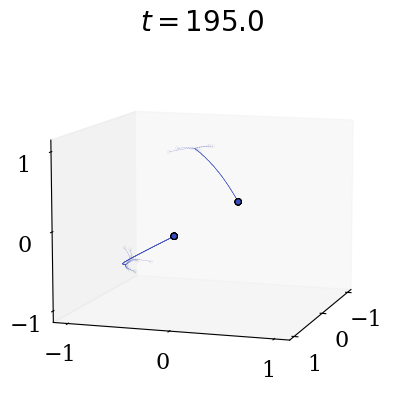

Time 195.00: Cluster Centers:
[[-1.00000000e+00 -1.23645648e-44  2.09693304e-44]
 [ 1.00000000e+00 -7.12166248e-44 -3.81056324e-44]
 [-1.00000000e+00 -1.23645648e-44  2.09693304e-44]]
Time 195.00: ARI = 0.5652, NMI = 0.7427, FMI = 0.7588, Silhouette Score = 1.0000, Distance between first two centers = 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


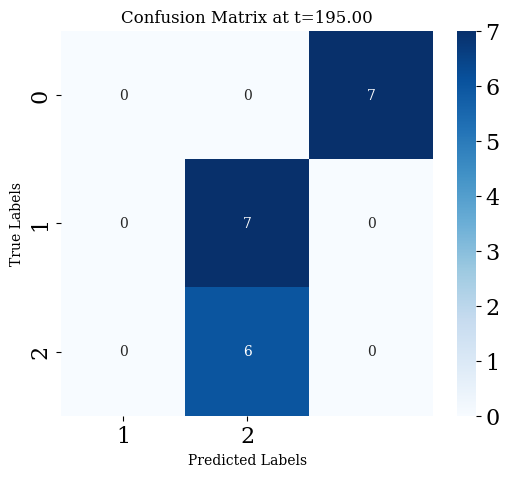

Time 195.00: Loss = -0.440693459922909
Time 195.10: Loss = -0.440876180936787
Time 195.20: Loss = -0.4410588613173994
Time 195.30: Loss = -0.44124150108672033
Time 195.40: Loss = -0.44142410026670637
Time 195.50: Loss = -0.44160665887930267
Time 195.60: Loss = -0.4417891769464372
Time 195.70: Loss = -0.4419716544900238
Time 195.80: Loss = -0.44215409153196417
Time 195.90: Loss = -0.44233648809414217
Time 196.00: Loss = -0.4425188441984297
Time 196.10: Loss = -0.44270115986668257
Time 196.20: Loss = -0.44288343512074346
Time 196.30: Loss = -0.44306566998243985
Time 196.40: Loss = -0.443247864473585
Time 196.50: Loss = -0.4434300186159773
Time 196.60: Loss = -0.4436121324314019
Time 196.70: Loss = -0.4437942059416282
Time 196.80: Loss = -0.44397623916841217
Time 196.90: Loss = -0.44415823213349404
Time 197.00: Loss = -0.4443401848586014
Time 197.10: Loss = -0.44452209736544673
Time 197.20: Loss = -0.44470396967572795
Time 197.30: Loss = -0.44488580181112863
Time 197.40: Loss = -0.4450675

In [178]:
# simulation loop

# scale factors by how much to spread a and v matrices
scale_a = 1
scale_v = 1
max_val = 1
x, A, V = reset(n, d, num_steps, scale_a, scale_v, max_val)

if classification_task:
    x, labels = init_x_blobs(n, d, num_steps, centers=3)
    norm_class_means = compute_class_means_on_hypersphere(x, labels)
    print(norm_class_means)
    visualize_initial_clusters(x, labels, norm_class_means, d=d, base_filename=base_filename)
    

for l, t in enumerate(integration_time):
    if l<num_steps-1:
        # Attention matrix
        # attention = [[compute_attention(A, x, i, j, n) for j in range(n)] for i in range(n)]
        if use_lnorm:
            # attention = l2_attention(A, x, l, sigma=1.0)
            x, attention = sphere_update(A, V, x, l, beta=beta)
        else:
            attention = [[1/np.sum(vanilla_attn(A, x, i, j, n)) for j in range(n)] for i in range(n)]
        attention = np.array(attention)
        # print(np.linalg.matrix_rank(attention))
        """
        To separate out Q and K matrices, we might index into X like so?
        Q = np.array([np.matmul(A, x[i,l]) for i in range(n)])  # Shape: (20, 2)
        K = x[:, l, :]  # Shape: (20, 2)
        """
        
        label_size = 0
        if round(t % viz_cadence, 10) == 0:
            # ensure the visualization works under larger dimension
            if d == 3:
                x_min, x_max = x[:, :, 0].min(), x[:, :, 0].max()
                y_min, y_max = x[:, :, 1].min(), x[:, :, 1].max()
                z_min, z_max = x[:, :, 2].min(), x[:, :, 2].max()

                margin = 0.1
                x_range = x_max - x_min
                x_min -= margin * x_range
                x_max += margin * x_range
                y_range = y_max - y_min
                y_min -= margin * y_range
                y_max += margin * y_range
                z_range = z_max - z_min
                z_min -= margin * z_range
                z_max += margin * z_range
                    
                    
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')
                label_size = 16
                plt.rcParams['xtick.labelsize'] = label_size
                plt.rcParams['ytick.labelsize'] = label_size

                plt.title(r'$t={t}$'.format(t=str(round(t, 2))), fontsize=20)

                # Plot current positions
                ax.scatter(
                    x[:, l, 0],
                    x[:, l, 1],
                    x[:, l, 2],
                    c=color,
                    alpha=1,
                    marker='o',
                    linewidth=0.75,
                    edgecolors='black'
                )

                # Plot starting positions
                ax.scatter(
                    x[:, 0, 0],
                    x[:, 0, 1],
                    x[:, 0, 2],
                    c='white',
                    alpha=0.1,
                    marker='.',
                    linewidth=0.3,
                    edgecolors='black',
                    zorder=3
                )

                # Plot trajectories
                if l > 0:
                    for i in range(n):
                        x_traj = x[i, :l+1, 0]
                        y_traj = x[i, :l+1, 1]
                        z_traj = x[i, :l+1, 2]
                        ax.plot(
                            x_traj,
                            y_traj,
                            z_traj,
                            c=color,
                            alpha=0.75,
                            linestyle='dashed',
                            linewidth=0.25
                        )

                # Set axis limits
                ax.set_xlim3d(x_min, x_max)
                ax.set_ylim3d(y_min, y_max)
#                 ax.set_zlim3d(z_min, z_max)
                ax.set_xlim3d(-1.1, 1.1)
                ax.set_ylim3d(-1.1, 1.1)
                ax.set_zlim3d(-1.1, 1.1)

                default_azim = 30  

                # the range of rotation around the default_azim
                rotation_range = 30
                total_frames = num_steps

                angle = default_azim + rotation_range * (t/total_frames - 0.5)  # will go from -15 to +15 degrees
                ax.view_init(elev=10, azim=angle)

                ax.grid(False)
                plt.locator_params(nbins=4)
                
                if save_fig:
                    plt.savefig(
                        os.path.join(result_dir, base_filename + "{}.pdf".format(l)),
                        format='pdf',
                        bbox_inches='tight'
                    )
                    plt.clf()
                    plt.close()
                else:
                    plt.show()
                
            elif d > 3:
                pca = PCA(n_components=2)
                reduced_x = pca.fit_transform(x[:, l, :])

                plt.scatter(reduced_x[:, 0], reduced_x[:, 1], c="#d91c72", alpha=1, marker='o', linewidth=0.75, edgecolors='black')
                plt.title(f't = {round(t, 2)}')
                plt.show()
            else:
                label_size = 0
                fig = plt.figure()
                ax = fig.add_subplot(1, 1, 1)
                label_size = 8
                plt.rcParams['xtick.labelsize'] = label_size
                plt.rcParams['ytick.labelsize'] = label_size 

                ax.set_aspect('equal', adjustable='box')
                # plt.rc('text', usetex=True)
                plt.rc('font', family='serif')
#                 print(A.shape, x[i,l].shape)
#                 print([np.matmul(A, x[i,l])[0] for i in range(n)])
#                 proj = np.matmul(A, x[i,:])
#                 print(proj.shape)
                plt.scatter([np.matmul(A, x[i,l])[0] for i in range(n)],
                            [np.matmul(A, x[i,l])[1] for i in range(n)],
                            c="#a8deb5", 
                            alpha=1, 
                            marker = 'o', 
                            linewidth=0.75, 
                            edgecolors='black', 
                            zorder=3)

                plt.scatter([x[i,l][0] for i in range(n)],
                            [x[i,l][1] for i in range(n)],
                            c="#d91c72", 
                            alpha=1, 
                            marker = 'o', 
                            linewidth=0.75, 
                            edgecolors='black', 
                            zorder=3)

                plt.title(r'$t={t}$'.format(t=str(round(t, 2))), fontsize=20)

                for i in range(n):
                    for j in range(n):
                        if attention[i][j]>1e-4 and i!=j:
                            plt.plot([np.matmul(A, x[i,l])[0], x[j,l][0]], 
                                      [np.matmul(A, x[i,l])[1], x[j,l][1]],
                                      linewidth=attention[i][j]*1e-6,
                                      color="black")

                ax.set_yticklabels([])
                ax.set_xticklabels([])
                
                if save_fig:
                    plt.savefig("{}/connect-{}.pdf".format(result_dir, round(t, 2)), 
                                format='pdf', 
                                bbox_inches='tight')
                else:
                    plt.show()
            
        if calc_k_means and round(t % kmeans_cadence, 10) == 0:
            positions = x[:, l, :]
            try:
                kmeans = KMeans(n_clusters=num_classes, random_state=42).fit(positions)
                labels_pred = kmeans.labels_
                cluster_centers = kmeans.cluster_centers_
                print(f"Time {t:.2f}: Cluster Centers:\n{cluster_centers}")

                # Compute evaluation metrics
                ari = adjusted_rand_score(labels, labels_pred)
                nmi = normalized_mutual_info_score(labels, labels_pred)
                fmi = fowlkes_mallows_score(labels, labels_pred)
                score = silhouette_score(positions, labels_pred)

                # Compute distance between cluster centers (for first two clusters as an example)
                if num_classes >= 2:
                    distance_between_centers = np.linalg.norm(cluster_centers[0] - cluster_centers[1])
                else:
                    distance_between_centers = 0.0  # Not applicable for single cluster

                # Print the scores
                print(f"Time {t:.2f}: ARI = {ari:.4f}, NMI = {nmi:.4f}, FMI = {fmi:.4f}, Silhouette Score = {score:.4f}, Distance between first two centers = {distance_between_centers:.4f}")

                if heatmap:
                    cm = confusion_matrix(labels, labels_pred)
                    plt.figure(figsize=(6,5))
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels_pred), yticklabels=np.unique(labels))
                    plt.xlabel('Predicted Labels')
                    plt.ylabel('True Labels')
                    plt.title(f'Confusion Matrix at t={t:.2f}')
                    plt.show()

            except ConvergenceWarning as e:
                print(f"Time {t:.2f}: An error occurred during KMeans evaluation - {e}")
            
        
        # update v if classification
        if classification_task:
            # Forward pass
            logits = np.matmul(x[:, l, :], A.T)       # Shape: (n, d)
            logits = np.matmul(logits, V.T)           # Shape: (n, d)
            logits = np.sum(logits, axis=1) + b       # Shape: (n,)

            # Compute probabilities and loss
            probs = 1 / (1 + np.exp(-logits))         # Sigmoid activation
            loss = -np.mean(labels * np.log(probs + 1e-7) + (1 - labels) * np.log(1 - probs + 1e-7))
            print(f"Time {t:.2f}: Loss = {loss}")

            # Backward pass (compute gradients)
            dL_dlogits = (probs - labels) / n        # Shape: (n,)

            # Compute the common term for gradients
            common_term = np.dot(dL_dlogits, x[:, l, :])  # Shape: (d,)

            # Gradient w.r.t V
            # Each grad_V[k, p] = A[k, p] * sum_i(dL_dlogits[i] * x[i, p])
            grad_V = A * common_term[np.newaxis, :]       # Broadcasting to (d, d)

            # Gradient w.r.t A
            # Each grad_A[k, p] = V[k, p] * sum_i(dL_dlogits[i] * x[i, p])
            grad_A = V * common_term[np.newaxis, :]       # Broadcasting to (d, d)

            # Update V and A
            V -= learning_rate * grad_V
            # A -= learning_rate * grad_A
        
        # perform particle position update
        # there is a massive difference between pre-layer norm and post-layer norm
        
        # x = euler_update(attention, V, x, n, dt)
        
#         x[:,l+1,:] = rk4_with_attention(attention, V, x, n, dt)
        if use_lnorm:
            x[:, l+1, :] = layer_normalize(x[:, l+1, :], radius=1)
            
        plt.clf()
        plt.close()

## Experiments with deliberate clustering

Idea: if we force clusters in V and A, so that they are aligned with clusters, the hypothesis is that they will get more drastically separated from eachother with time

In [179]:
colors = ["#a8deb5", "#a5d8ff", "#ffb3c1", "#c1caff"] # cikir per cluster

In [ ]:
cluster_labels = np.array([
        i for i in range(num_clusters) for _ in range(particles_per_cluster)
    ])

In [ ]:
# Simulation Loop
for l, t in enumerate(integration_time):
    if l < num_steps - 1:
        # Compute Attention Matrix
        attention_matrix = np.array([
            [
                1 / np.sum([
                    np.exp(np.dot(A @ x[i, l], x[k, l] - x[j, l]))
                    for k in range(n)
                ]) 
                for j in range(n)
            ] 
            for i in range(n)
        ])
        rank = np.linalg.matrix_rank(attention_matrix)
        print(f"Time {t:.2f}: Attention Matrix Rank = {rank}")
        
        # Update Transformation Matrix A (modular, can be swapped out)
#         A = update_A(attention_matrix, x[:, l, :], n, d)
        
#         # Update Transformation Influence Matrix V (modular, can be swapped out)
#         V = update_V(A, num_clusters)
        
        # Visualization at every 0.5 time units
        if np.isclose(t % 0.5, 0, atol=1e-8):
            visualize(
                x=x[:, l, :],
                A=A,
                attention_matrix=attention_matrix,
                cluster_labels=cluster_labels,
                colors=colors,
                t=t,
                show=True
            )
        
        # update particle state
        x = euler_update(attention, V, x, n, dt)

## Rank Collapse

In [ ]:
def rk4(V, x, n):
    "Runge-Katta forth degree"
    for i in range(n):
        k1 = dt*np.matmul(V, x[i][l])
        k2 = dt*np.matmul(V, x[i][l] + 0.5*k1)
        k3 = dt*np.matmul(V, x[i][l] + 0.5*k2)
        k4 = dt*np.matmul(V, x[i][l] + k3)
        dynamics = (1/6)*(k1 + 2*k2 + 2*k3 + k4)
        x[i][l+1] = x[i][l] + dynamics
    return x

In [ ]:
# we can do far fewer iterations when illustrating rank collapse
T = 2.0
num_steps = int(T/dt) + 1
integration_time = np.linspace(0, T, num_steps)

# much higher dim
d = 100
A = init_A(d)
V = init_V(d)
x = init_x(n, d, num_steps)

20


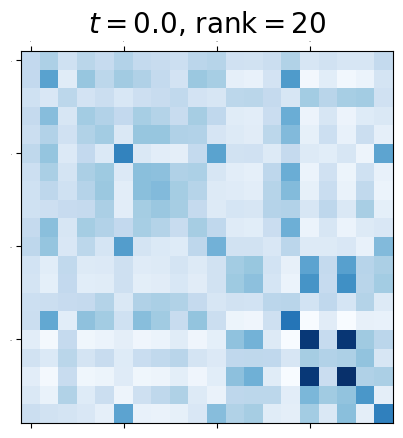

20


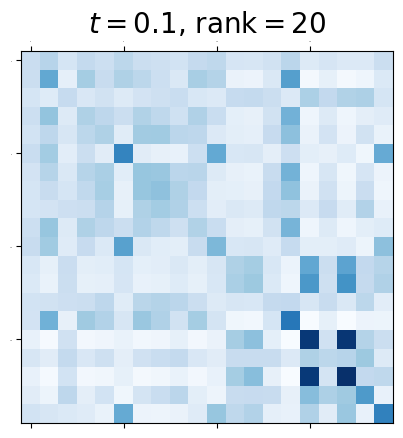

20


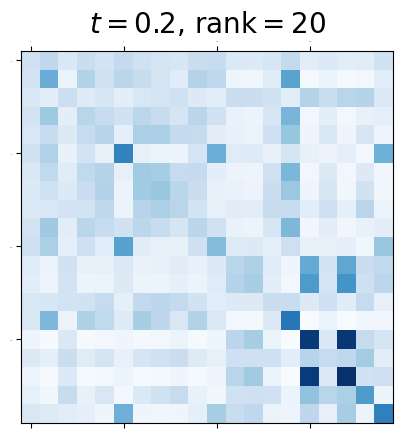

20


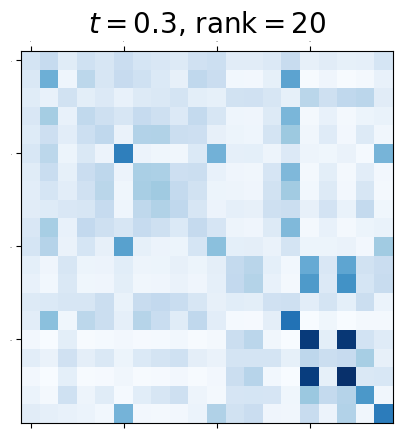

20


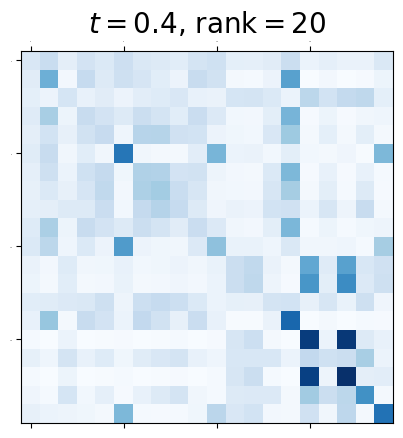

20


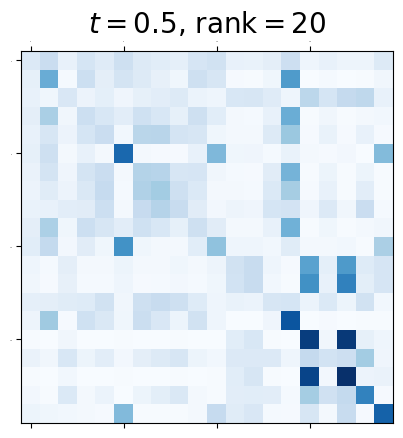

20


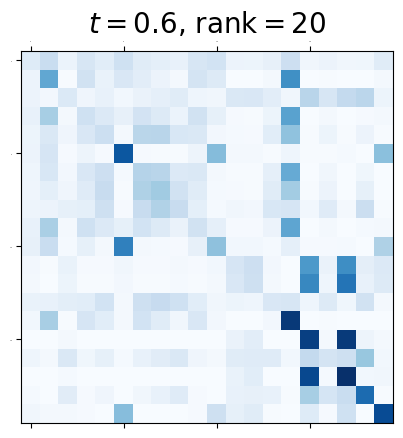

20


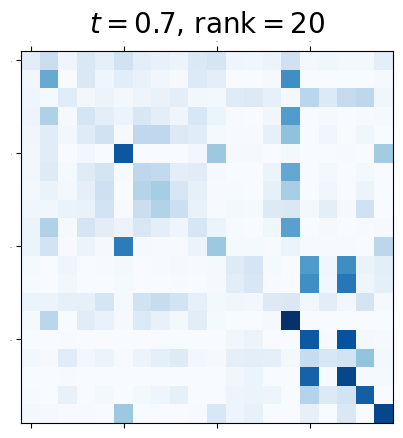

20


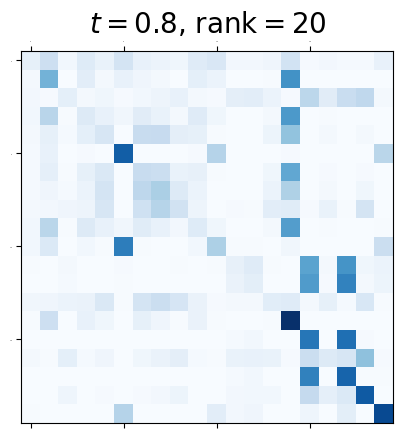

20


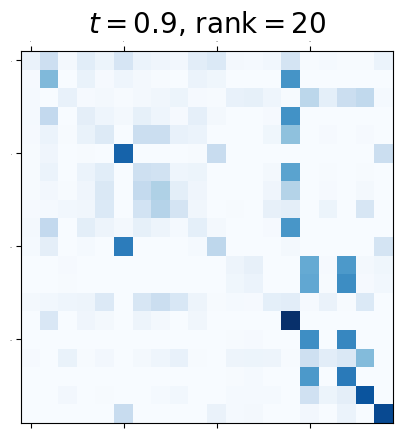

20


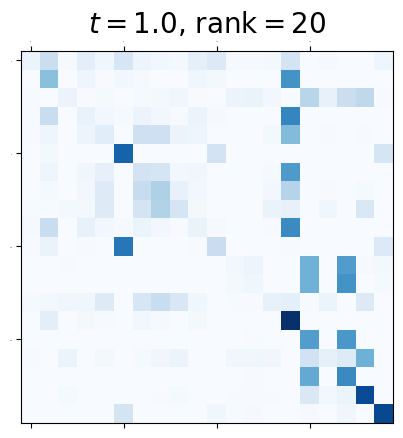

20


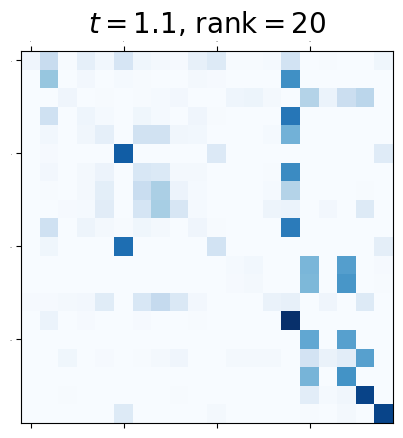

20


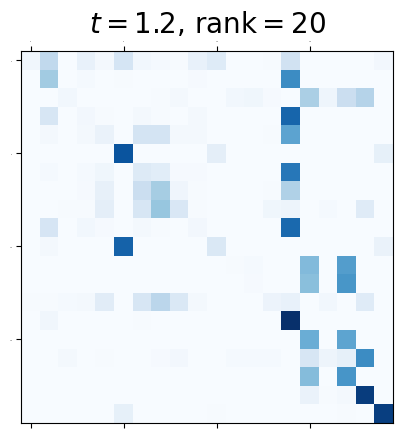

20


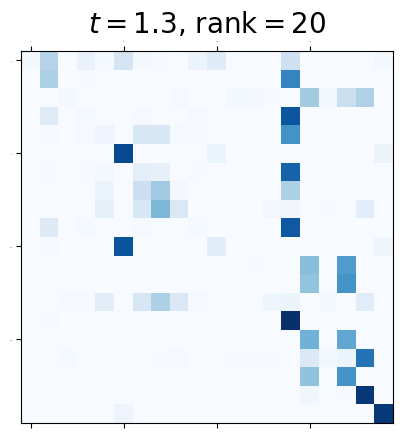

20


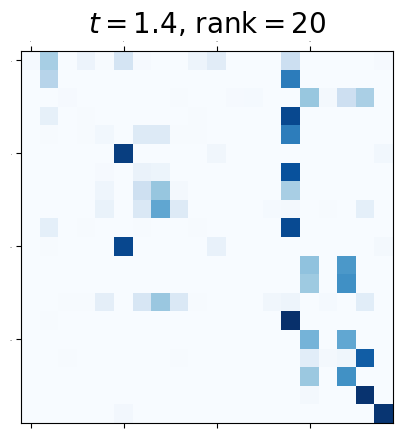

20


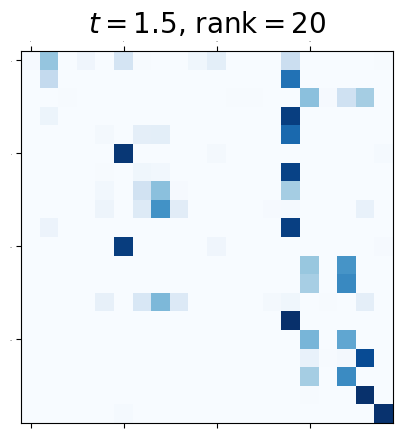

20


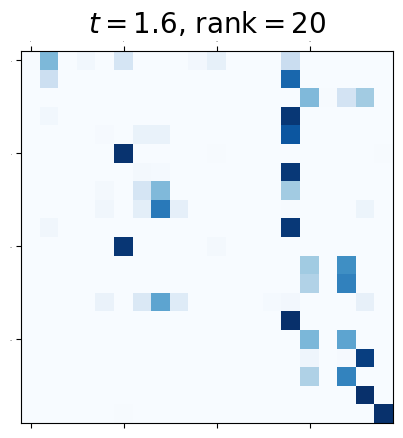

20


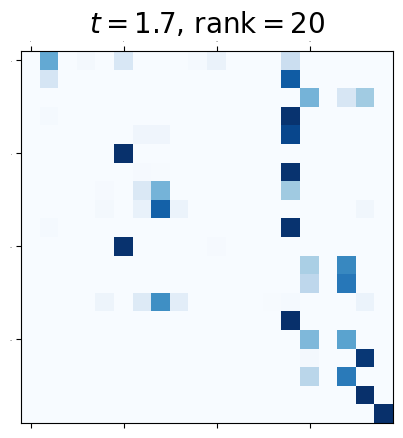

20


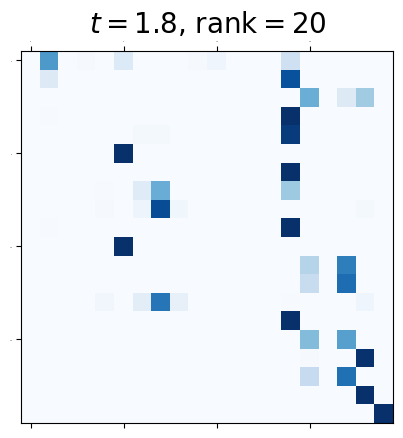

20


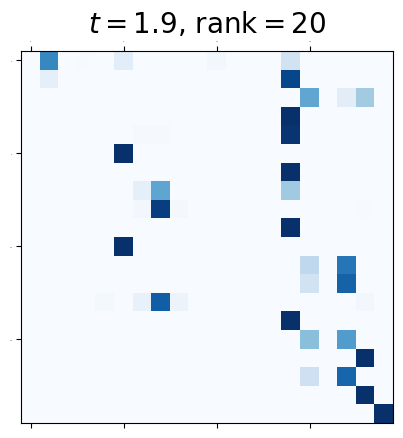

20


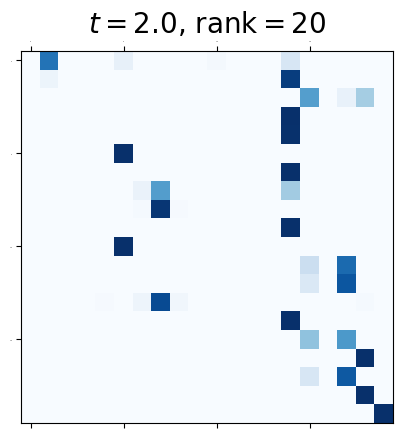

19


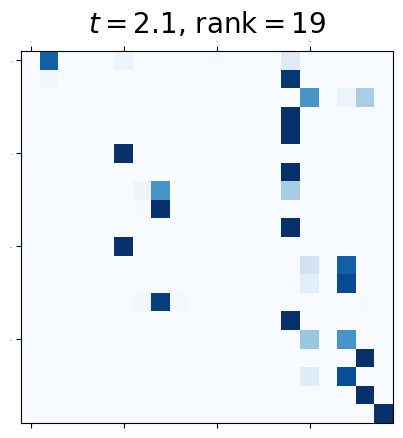

18


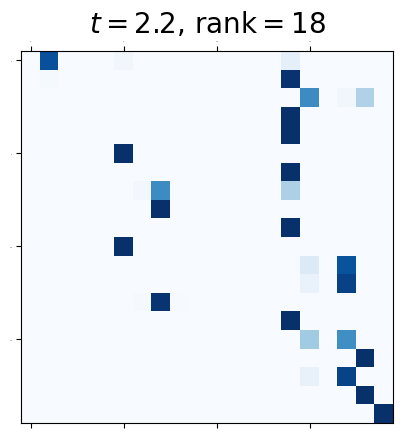

17


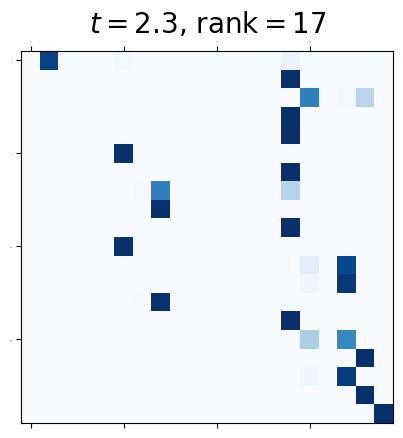

15


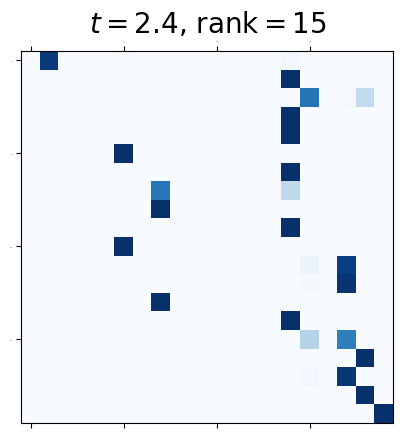

14


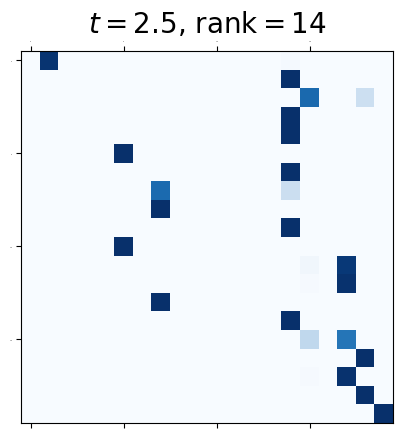

11


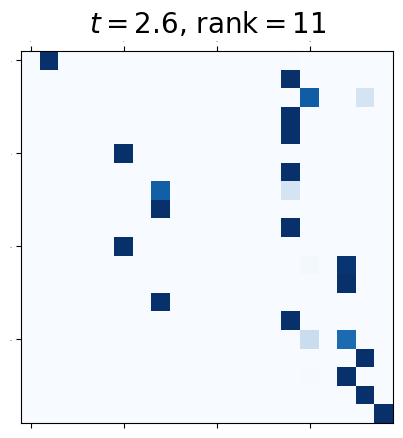

11


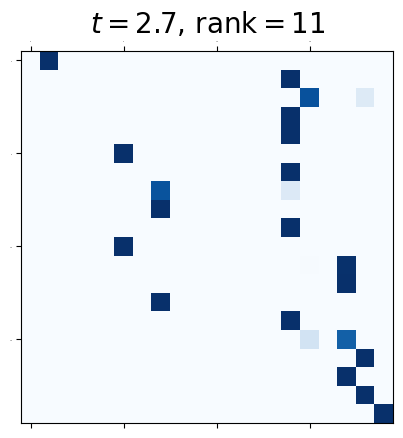

10


/scratch/902496/ipykernel_2044085/2639188945.py:4: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


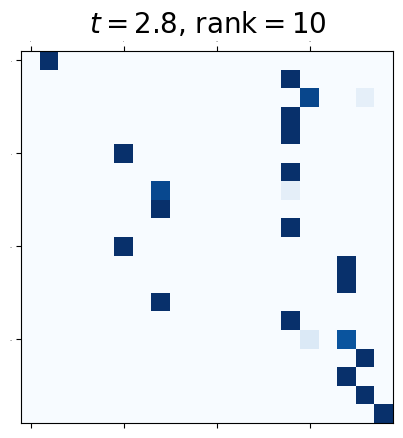

10


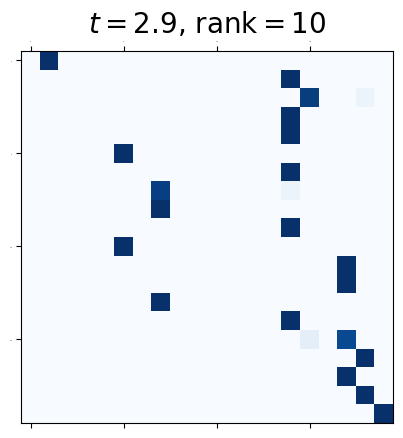

10


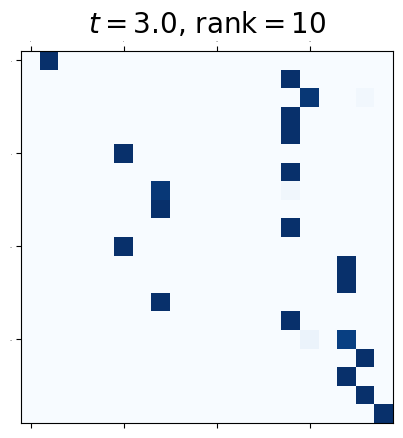

10


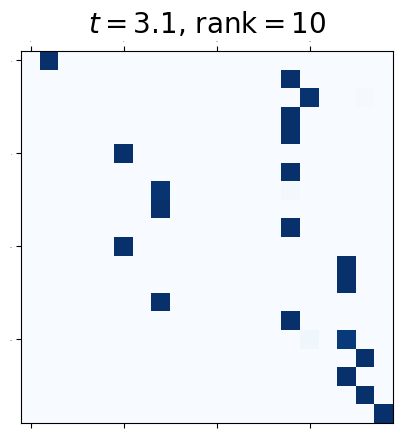

9


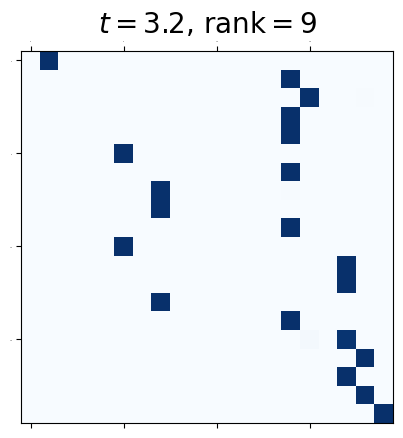

9


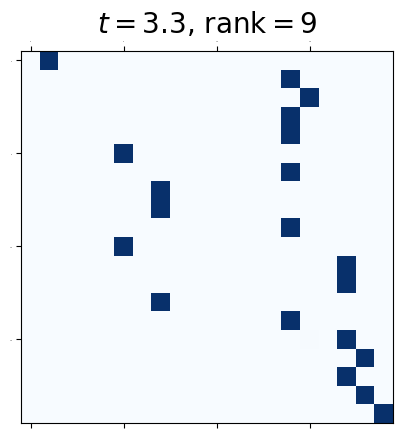

8


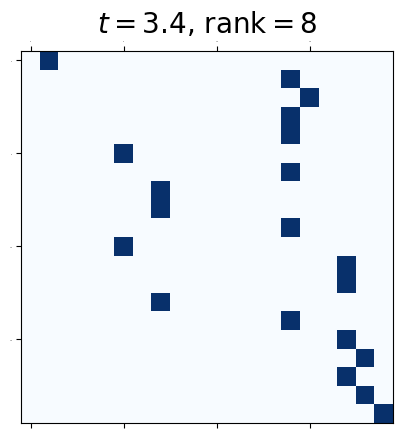

8


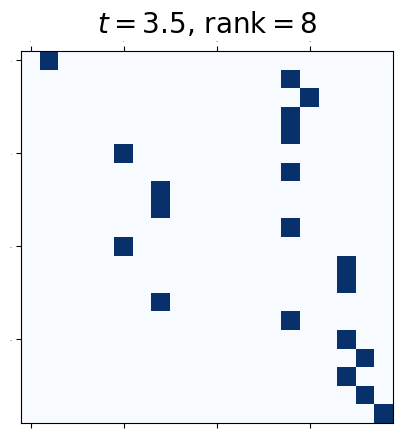

8


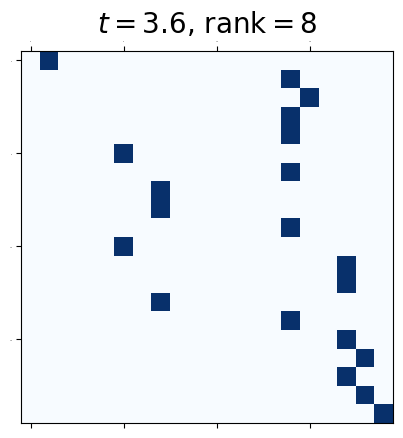

8


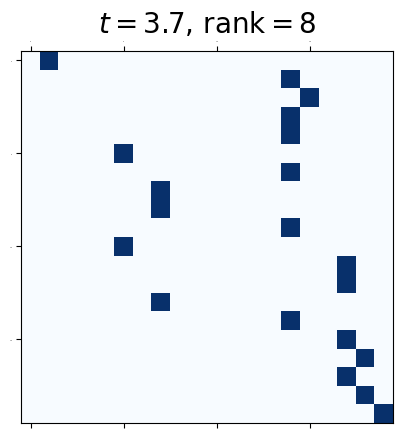

8


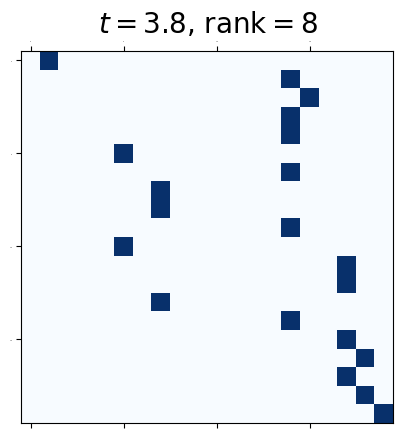

8


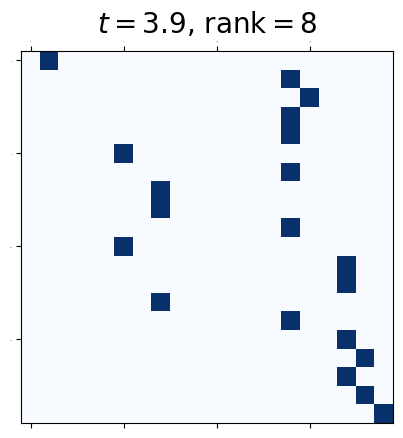

8


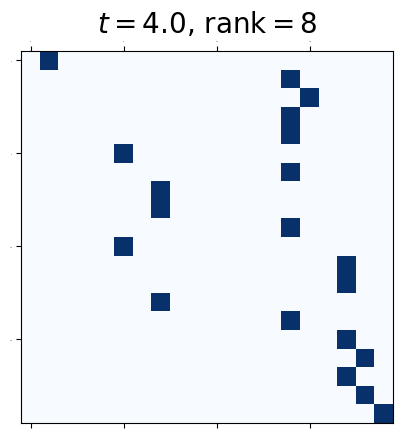

8


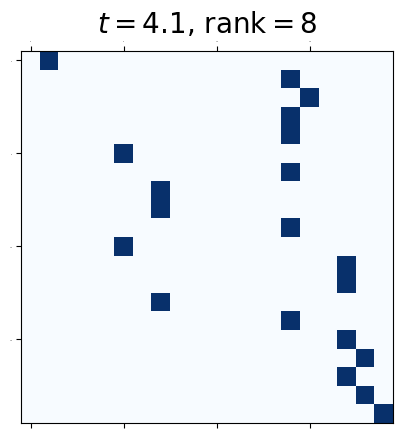

8


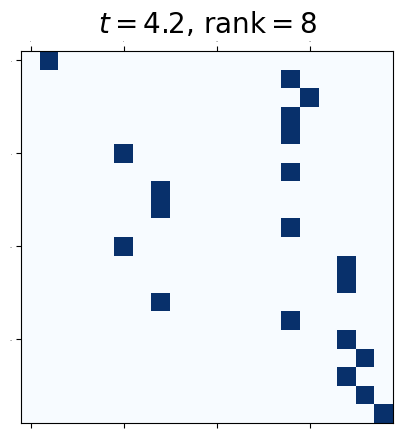

8


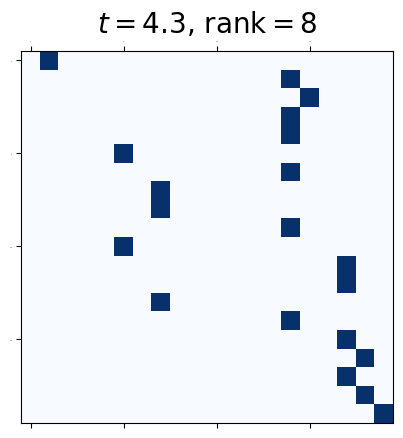

8


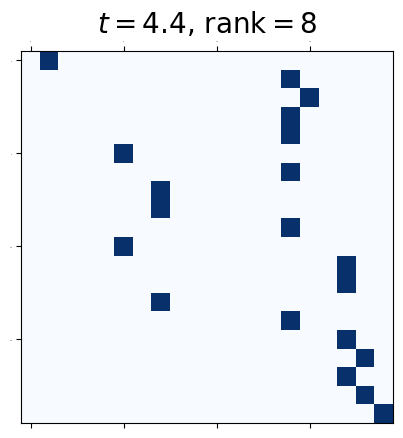

8


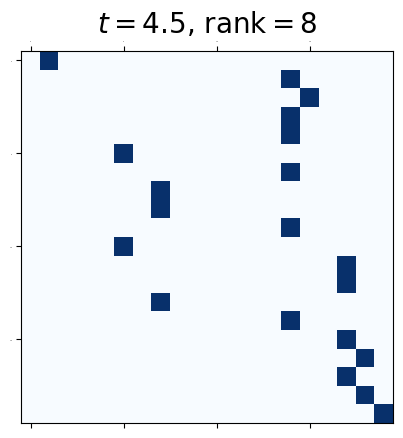

8


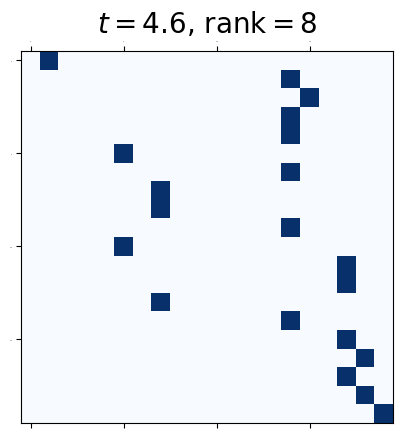

8


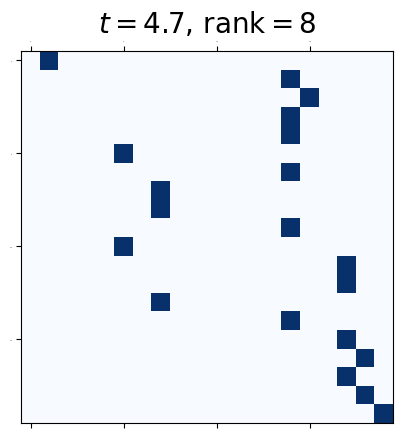

8


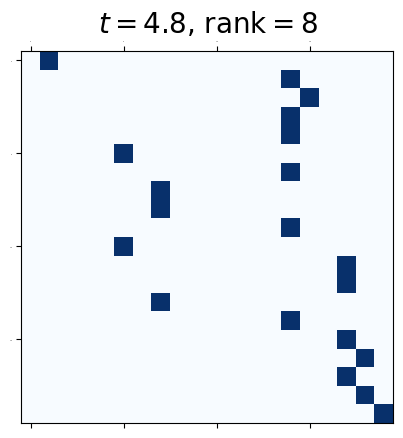

8


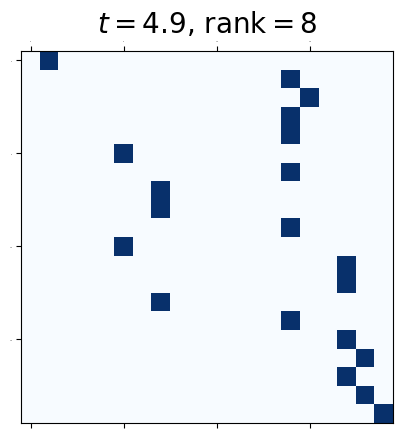

8


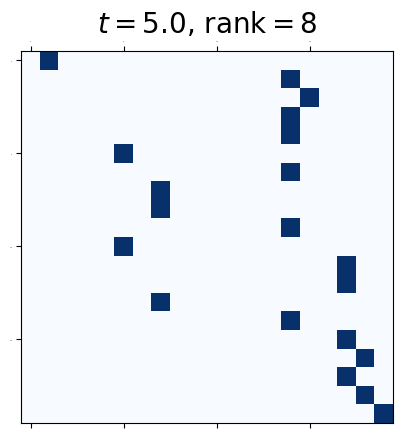

8


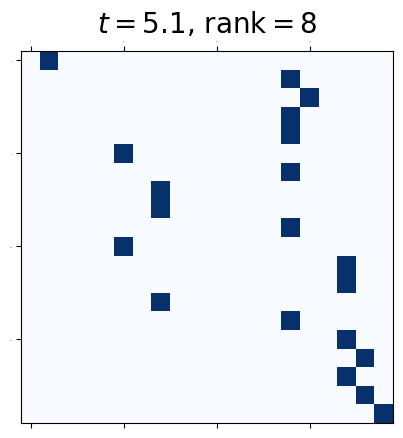

8


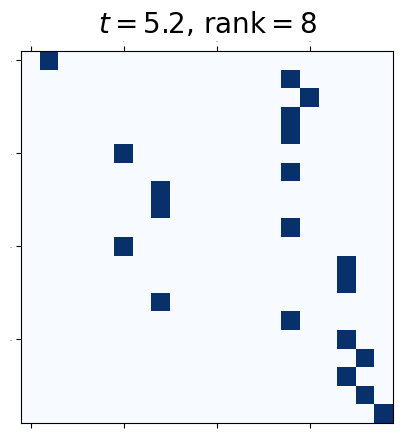

8


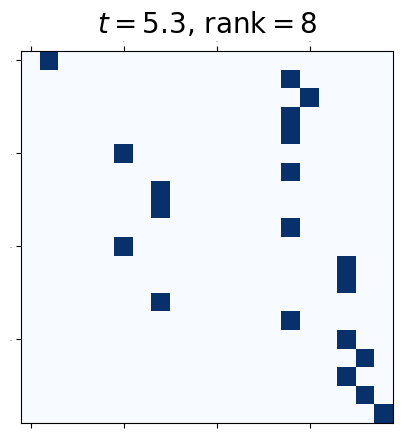

8


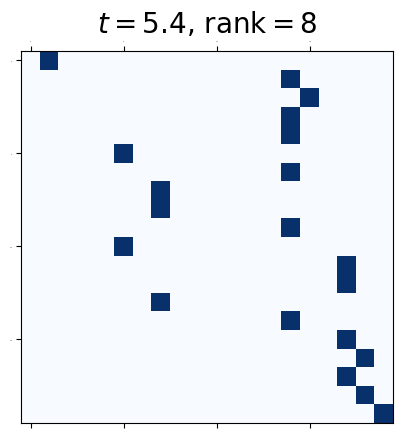

8


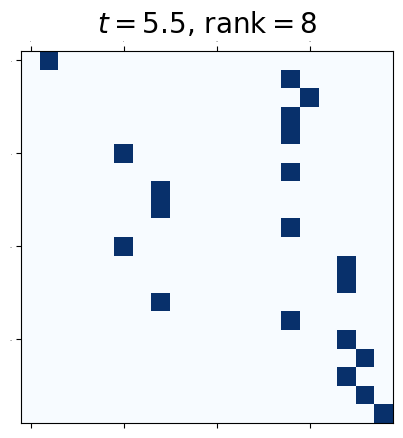

8


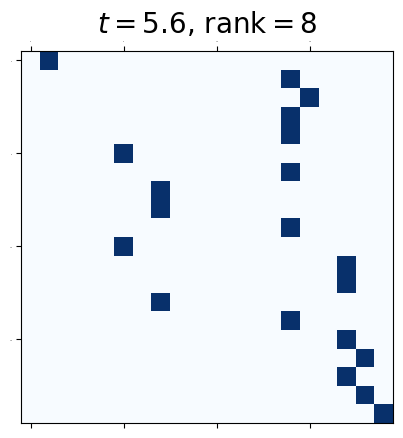

8


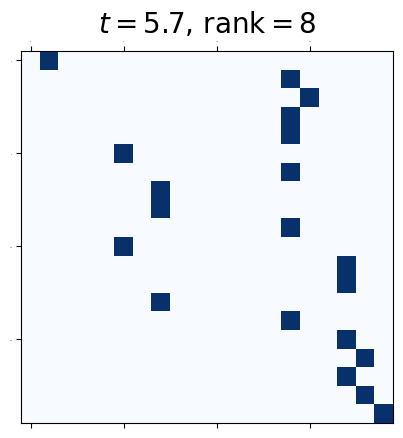

8


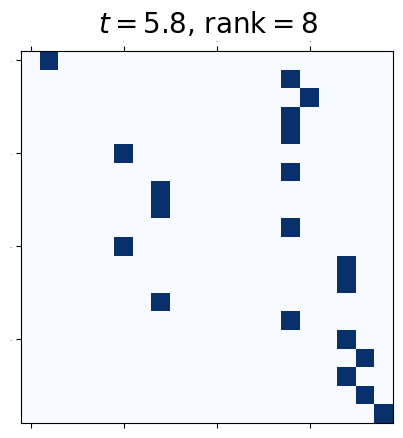

8


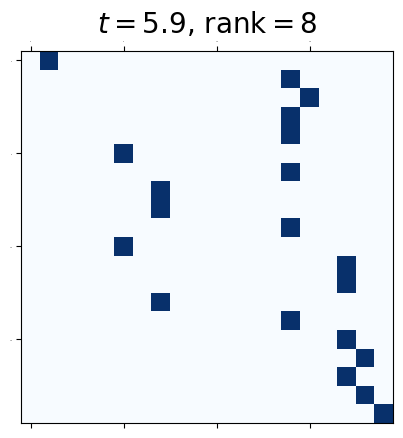

In [89]:
# simulation
for l, t in enumerate(integration_time):
    if l<num_steps-1:
        attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]
        print(np.linalg.matrix_rank(attention))

        label_size = 0
        plt.matshow(attention, cmap="Blues")
        plt.rcParams['xtick.labelsize'] = label_size
        plt.rcParams['ytick.labelsize'] = label_size
        plt.title(r'$t={t}$, rank$={r}$'.format(t=str(round(t, 2)), r=str(np.linalg.matrix_rank(attention))), fontsize=20)
        plt.show()

        plt.clf()
        plt.close()
            
        # perform update, this one is rkhf
        x = rk4(attention, V, x, n, dt) 

# Main experiment using transformer

Haven't imlemented this one, but they look at albert weights

In [ ]:
import numpy as np
import scipy as sp
import imageio
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
import os
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull
from datetime import datetime


def get_dynamics(z_curr, attention, V, i):
    """
    - Returns: the dynamics z'(t) = (z_1'(t), ... , z_n'(t)) at some time-step t.
    """
    
    dlst = np.array([attention[i][j]*np.matmul(V, z_curr[j]-z_curr[i]) for j in range(n)])
    return np.sum(dlst, axis=0)

def transformer(T, dt, n, d, A, V, x0):
    """
    - Returns: the evolution of z = (z_1, ..., z_n) over time.
    """
    
    num_steps = int(T/dt)+1
    z = np.zeros(shape=(n, num_steps, d))
    z[:, 0, :] = x0
    integration_time = np.linspace(0, T, num_steps)

    for l, t in enumerate(integration_time):
        if l < num_steps - 1:
            # Attention matrix
            attention = [[1/np.sum([np.exp(np.dot(np.matmul(np.matmul(A, sp.linalg.expm(V*t)), z[i][l]), np.matmul(np.matmul(A, sp.linalg.expm(V*t)), z[k][l]-z[j][l]))) for k in range(n)]) for j in range(n)] for i in range(n)]
            
            z_next = np.zeros((n, d))
            for i in range(n):
                k1 = dt * get_dynamics(z[:, l, :], attention, V, i)
                k2 = dt * get_dynamics(z[:, l, :] + k1 / 2, attention, V, i)
                k3 = dt * get_dynamics(z[:, l, :] + k2 / 2, attention, V, i)
                k4 = dt * get_dynamics(z[:, l, :] + k3, attention, V, i)
                
                z_next[i] = z[i][l] + (k1 + 2*k2 + 2*k3 + k4) / 6
        
            z[:, l+1, :] = z_next
    return z

def calculate_distance_from_viewing_direction(point):
    viewing_direction = np.array([1, 0, 0])
    return np.linalg.norm(point - viewing_direction)

def visuals(d, 
            dt, 
            z, 
            integration_time, 
            conv, 
            color, 
            show_polytope, 
            movie, 
            dir_path, 
            base_filename):
    """
    Plots several snapshots of the trajectories {z_i(t)}_{i\in[n]}, and a movie thereof
    if indicated.
    """
    
    x_min, x_max = z[:, :, 0].min(), z[:, :, 0].max()
    if d>1:
        y_min, y_max = z[:, :, 1].min(), z[:, :, 1].max()
        if d == 3:
            z_min, z_max = z[:, :, 2].min(), z[:, :, 2].max()
    
    margin = 0.1
    x_range = x_max - x_min
    x_min -= margin * x_range
    x_max += margin * x_range

    if d>1:
        y_range = y_max - y_min
        y_min -= margin * y_range
        y_max += margin * y_range
        if d == 3:
            z_range = z_max - z_min
            z_min -= margin * z_range
            z_max += margin * z_range
    
    interp_x = []
    interp_y = []
    interp_z = []

    for i in range(n):
        interp_x.append(interp1d(integration_time, z[i, :, 0], 
                                 kind='cubic', 
                                 fill_value='extrapolate'))
        if d>1:
            interp_y.append(interp1d(integration_time, z[i, :, 1], 
                                     kind='cubic', 
                                     fill_value='extrapolate'))
            if d==3:
                interp_z.append(interp1d(integration_time, z[i, :, 2], 
                                         kind='cubic', 
                                         fill_value='extrapolate'))
                
    rc("text", usetex = True)
    font = {'size'   : 16}
    rc('font', **font)
    
    for t in range(num_steps):
        if d == 2 and round(t*dt % 0.5, 10) == 0:
            label_size = 16
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            plt.rcParams['xtick.labelsize'] = label_size
            plt.rcParams['ytick.labelsize'] = label_size 
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            plt.title(r'$t={t}$'.format(t=str(round(t*dt, 2))), fontsize=20)
                
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
            ax.set_aspect('equal', adjustable='box')
            plt.rc('text', usetex=True)
            plt.rc('font', family='serif')
            plt.scatter([x(integration_time)[t] for x in interp_x], 
                        [y(integration_time)[t] for y in interp_y], 
                        c=color, 
                        alpha=1, 
                        marker = 'o', 
                        linewidth=0.75, 
                        edgecolors='black', 
                        zorder=3)
            
            plt.scatter([x(integration_time)[0] for x in interp_x], 
                        [y(integration_time)[0] for y in interp_y], 
                        c='white', 
                        alpha=0.1, 
                        marker = '.', 
                        linewidth=0.3, 
                        edgecolors='black', 
                        zorder=3)
            
            if t > 0:
                for i in range(n):
                    x_traj = interp_x[i](integration_time)[:t+1]
                    y_traj = interp_y[i](integration_time)[:t+1]
                    plt.plot(x_traj, 
                             y_traj, 
                             c=color, 
                             alpha=1, 
                             linewidth = 0.25, 
                             linestyle = 'dashed',
                             zorder=1)
            if conv:
                points = np.array([[z[i, t, 0], 
                                    z[i, t, 1]] for i in range(n)])
                hull = ConvexHull(points)
                for simplex in hull.simplices:
                    plt.plot(points[simplex, 0], 
                             points[simplex, 1], 
                             color='silver',
                             linewidth = 0.5,
                             alpha=1)
            
            plt.savefig(base_filename + "{}.pdf".format(t), 
                        format='pdf', 
                        bbox_inches='tight')
                    
        elif d == 3 and round(t*dt % 0.5, 10) == 0:
            fig = plt.figure()
            ax = Axes3D(fig)
            label_size = 16
            plt.rcParams['xtick.labelsize'] = label_size
            plt.rcParams['ytick.labelsize'] = label_size
            
            plt.title(r'$t={t}$'.format(t=str(round(t*dt,2))), fontsize=20)
                
            ax.scatter([x(integration_time)[t] for x in interp_x], 
                        [y(integration_time)[t] for y in interp_y],
                        [z(integration_time)[t] for z in interp_z],
                        c=color, 
                        alpha=1, 
                        marker = 'o', 
                        linewidth=0.75, 
                        edgecolors='black')
            plt.rc('text', usetex=True)
            plt.rc('font', family='serif')
            
            ax.scatter([x(integration_time)[0] for x in interp_x], 
                        [y(integration_time)[0] for y in interp_y],
                        [z(integration_time)[0] for z in interp_z], 
                        c='white', 
                        alpha=0.1, 
                        marker = '.', 
                        linewidth=0.3, 
                        edgecolors='black', 
                        zorder=3)
            
            if t > 0:
                for i in range(n):
                    x_traj = interp_x[i](integration_time)[:t+1]
                    y_traj = interp_y[i](integration_time)[:t+1]
                    z_traj = interp_z[i](integration_time)[:t+1]
                    ax.plot(x_traj, 
                            y_traj, 
                            z_traj, 
                            c=color, 
                            alpha=0.75, 
                            linestyle = 'dashed',
                            linewidth = 0.25)
            
            ax.set_xlim3d(x_min, x_max)
            ax.set_ylim3d(y_min, y_max)
            ax.set_zlim3d(z_min, z_max)
            
            ax.view_init(elev=10)
        
            ax.grid(False)
            plt.locator_params(nbins=4)
            
            if conv:
                points = np.array([[z[i, t, 0], 
                                    z[i, t, 1],
                                    z[i, t, 2]] for i in range(n)])
                hull = ConvexHull(points)
                for simplex in hull.simplices:
                    plt.plot(points[simplex, 0], 
                             points[simplex, 1], 
                             points[simplex, 2],
                             color='silver',
                             linewidth = 0.5,
                             alpha=1)
            
            plt.savefig(os.path.join(dir_path, base_filename + "{}.pdf".format(t)), 
                        format='pdf', 
                        bbox_inches='tight')
            
            if t == num_steps-1 and show_polytope:
                
                from mpl_toolkits.mplot3d.art3d import Poly3DCollection
                fig = plt.figure()
                ax = Axes3D(fig)
                plt.title("")
                fig.set_facecolor('white')
                ax.set_facecolor('white') 
                ax.grid(False) 
                ax.w_xaxis.pane.fill = False
                ax.w_yaxis.pane.fill = False
                ax.w_zaxis.pane.fill = False
                ax.set(xlabel='')

                # Remove y-axis label
                ax.set(ylabel='')
                ax.set_zlabel('')
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_zticks([])
                    
                ax.scatter([x(integration_time)[t] for x in interp_x], 
                            [y(integration_time)[t] for y in interp_y],
                            [z(integration_time)[t] for z in interp_z],
                            c=color, 
                            alpha=1, 
                            marker = 'o', 
                            linewidth=0.75, 
                            edgecolors='black')
                plt.rc('text', usetex=True)
                plt.rc('font', family='serif')
                
                ax.scatter([x(integration_time)[0] for x in interp_x], 
                            [y(integration_time)[0] for y in interp_y],
                            [z(integration_time)[0] for z in interp_z], 
                            c='white', 
                            alpha=0.1, 
                            marker = '.', 
                            linewidth=0.3, 
                            edgecolors='black', 
                            zorder=3)
                
                
                points = np.array([[z[i, t, 0], 
                                    z[i, t, 1],
                                    z[i, t, 2]] for i in range(n)])
                hull = ConvexHull(points)
                
                cmap = plt.cm.get_cmap("plasma")
                
                for s in hull.simplices:
                    s = np.append(s, s[0])  # Here we cycle back to the first vertex in each simplex.
                    poly = Poly3DCollection([points[s]])
                    
                    min_x = np.min(points[s][:, 0])
                    color = cmap(min_x / 8)
            
                    # Calculate alpha based on the minimum X-coordinate, with front facets being more transparent.
                    alpha = 0.35 - 0.15 * (min_x / 8)
                    
                    poly.set_facecolor((*color[:3], alpha))  # Set the facecolor with the calculated color and alpha value.
                    ax.add_collection3d(poly)
                    
                for i in range(n):
                    x_traj = interp_x[i](integration_time)[:t+1]
                    y_traj = interp_y[i](integration_time)[:t+1]
                    z_traj = interp_z[i](integration_time)[:t+1]
                    ax.plot(x_traj, 
                            y_traj, 
                            z_traj, 
                            c='#FA7000', 
                            alpha=1, 
                            linestyle = 'dashed',
                            linewidth = 0.6)
                   
                ax.view_init(elev=10)
                
                plt.savefig(os.path.join(dir_path, base_filename + "{}.pdf".format(t+1)), 
                            format='pdf', 
                            bbox_inches='tight')
         
        if movie:           
            plt.savefig(base_filename + "{}.png".format(t),
                        format='png', dpi=250, bbox_inches=None)
        plt.clf()
        plt.close()
        
    if movie:
        imgs = []
        for i in range(num_steps):
            img_file = base_filename + "{}.png".format(i)
            imgs.append(imageio.imread(img_file))
            os.remove(img_file) 
        imageio.mimwrite(os.path.join(dir_path, filename), imgs)
 

geometries = ["polytope", "hyperplanes", "codimension-k", "hyperplanes x polytope"]
T = 5
dt = 0.1
n = 20
d = 2
x0 = np.random.uniform(low=-5, high=5, size=(n, d))
num_steps = int(T/dt)+1
integration_time = np.linspace(0, T, num_steps)

movie = False
conv = False
show_polytope = False

# An example
choice = "polytope"

if choice not in geometries:
    import sys
    print("Element is not in the list")
    sys.exit()
print("Element is in the list")

if choice == "polytope":
    # Theorem 3.2 (Clustering to a convex polytope)
    A = np.eye(d)
    V = np.eye(d)
    dir_path = './Th31'
    color = '#FA7000'
    conv = True

if choice == "hyperplanes":
    # Theorem 3.1 (Clustering to hyperplanes)
    A = np.eye(d)
    V = np.random.rand(d, d)
    V = np.abs(V)               # Perron Frobenius
    print("Eigenvalues of V:")
    print(np.linalg.eigvals(V))
    # Example in paper (2d):
    # V = np.array([[0.64709742, 0.81911926],
    #                0.61210449, 0.63263484]])
    # Example in paper (3d; Re(l)<0):
    # V = np.array([[0.2362413 , 0.0599536 , 0.40506019],
    #         [0.81321448, 0.49948705, 0.33754772],
    #         [0.2160645 , 0.38505272, 0.14588075]])
    # # Example 2 in paper (3d; Re(l)>0):
    # V = np.array([[0.18608476, 0.34391026, 0.13905949],
    #         [0.35244288, 0.6694859 , 0.39992145],
    #         [0.46685606, 0.17094454, 0.42092308]])
    dir_path = './Th41'
    color = '#3a4cc1'

if choice == "codimension-k":
    # Conjecture (codimension-k)
    A = np.eye(d)
    V = np.random.rand(d, d)
    V = (V+V.T)/2
    print("Eigenvalues of V:")
    print(np.linalg.eigvals(V))
    # Example in paper: Real eigenvalues (2 positive, 1 negative)
    # V = np.array([[0.92761287, 0.94333073, 0.3827744 ],
    #         [0.94333073, 0.59991396, 0.47825472],
    #         [0.3827744 , 0.47825472, 0.46668605]])
    dir_path = './Conj'
    color = '#9f4292'

if choice == "hyperplanes x polytope":
    # Theorem 5.1 (Clustering to a polytope and hyperplane)
    A = np.eye(d)
    # Example in paper:
    V = np.eye(d)
    V[-1][-1] = -0.5
    dir_path = './Th51'
    color = '#63acbe'
    conv = True
    
# The trajectories
z = transformer(T, dt, n, d, A, V, x0)

# Set the directory path where you want to save the pictures
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

# Generate the filename using the current datetime
now = datetime.now()
dt_string = now.strftime("%H-%M-%S")
filename = dt_string + ".gif"
base_filename = dt_string 
    
visuals(d, dt, z, integration_time, conv, color, show_polytope, movie, dir_path, base_filename)

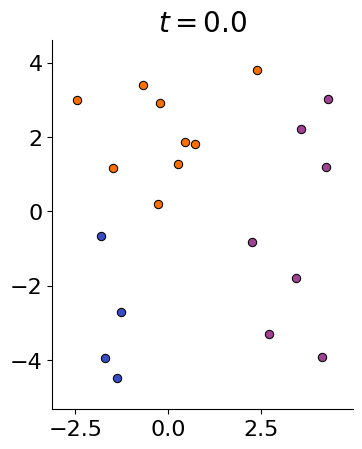

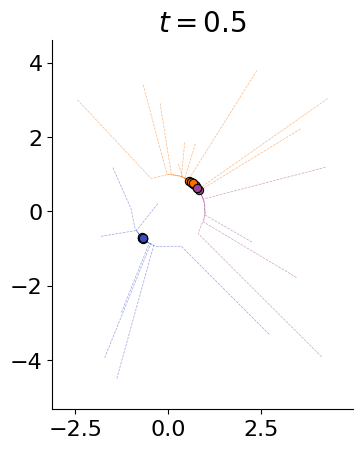

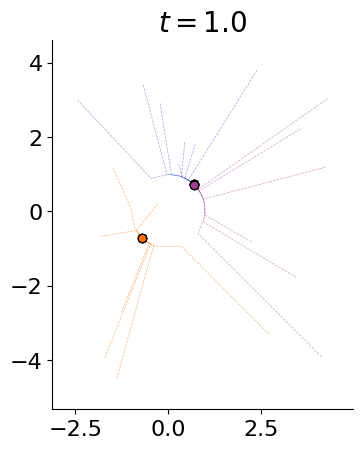

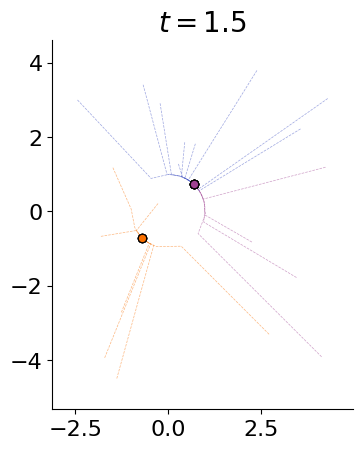

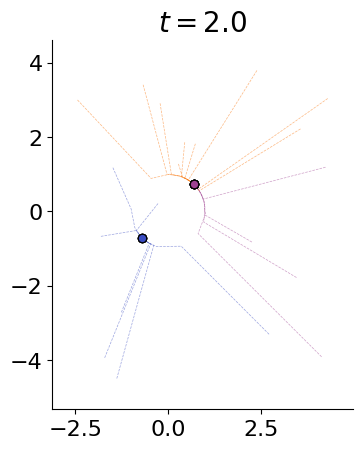

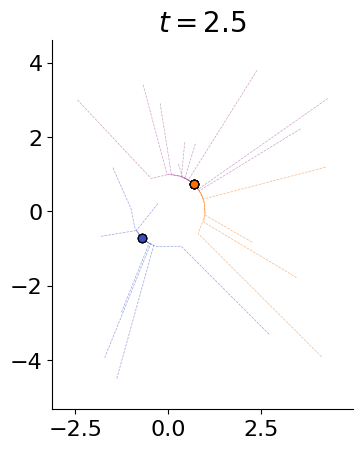

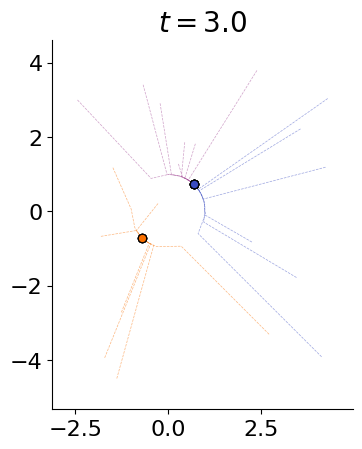

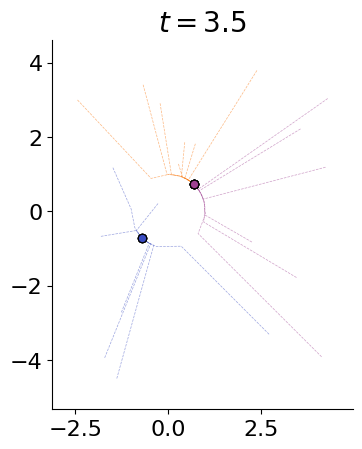

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


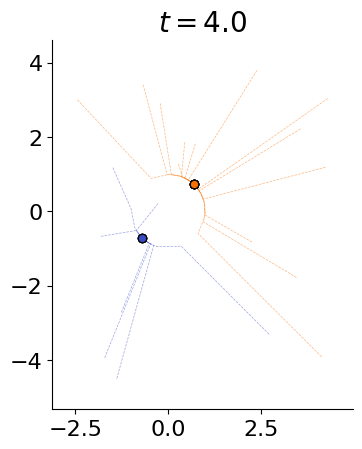

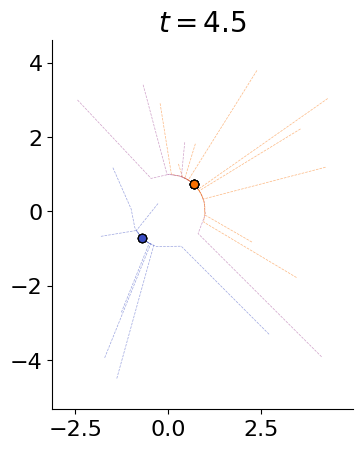

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


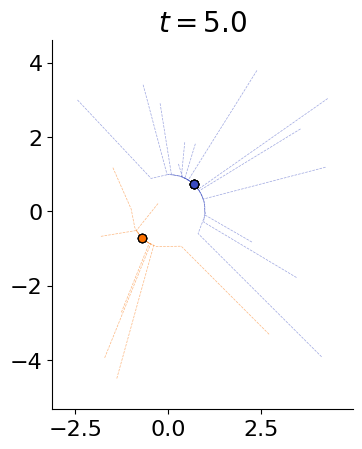

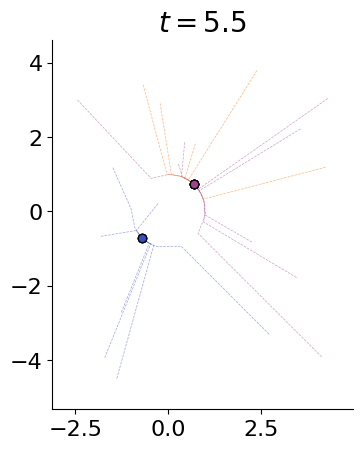

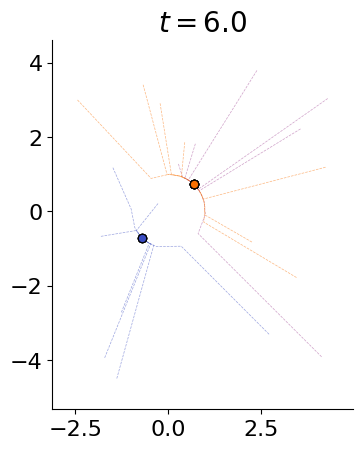

In [134]:
# we can allow the k and v seqlen to be different from q
num_queries = 10
m = 20

# Initialize query tokens (q_i), key tokens (k_i), and value tokens (v_i)
q0 = np.random.uniform(low=-5, high=5, size=(n, d))

# instead of randomly generating these, we could force assign them to clusters

m = 60
centers = [(-1, -1), (1, 0), (0, 1)]
k, true_labels = make_blobs(n_samples=m, centers=centers, cluster_std=1.0, random_state=42)
v = k.copy()  # Use the same values for v for simplicity
# k = np.random.uniform(low=-5, high=5, size=(m, d))
# v = np.random.uniform(low=-5, high=5, size=(m, d))

# arr = np.ones((n, d))
# q0, k, v = arr, arr * 2, arr * 3

def get_dynamics_cross_attention(q_curr, k, v, i):
    """
    Compute the dynamics for query token q_i using cross-attention.
    """
    # Compute attention weights between q_i and all key tokens
    scores = np.array([np.dot(np.matmul(A, q_curr[i]), np.matmul(A, k_j)) for k_j in k])
    attention_weights = np.exp(scores) / np.sum(np.exp(scores))
    
    # Compute the weighted sum of value tokens
    weighted_v = np.sum([attention_weights[j] * v[j] for j in range(len(k))], axis=0)
    
    # Compute the dynamics
    dz_dt = np.matmul(V, weighted_v - q_curr[i])
    return dz_dt

def transformer_cross_attention(T, dt, n, d, A, V, q0, k, v):
    """
    Simulate the dynamics of query tokens under cross-attention.
    """
    num_steps = int(T/dt) + 1
    q = np.zeros((n, num_steps, d))
    q[:, 0, :] = q0

    for l in range(num_steps - 1):
        q_next = np.zeros((n, d))
        for i in range(n):
            # Runge-Kutta 4th order method for integration
            k1 = dt * get_dynamics_cross_attention(q[:, l, :], k, v, i)
            k2 = dt * get_dynamics_cross_attention(q[:, l, :] + k1 / 2, k, v, i)
            k3 = dt * get_dynamics_cross_attention(q[:, l, :] + k2 / 2, k, v, i)
            k4 = dt * get_dynamics_cross_attention(q[:, l, :] + k3, k, v, i)
            
            q_next[i] = q[i, l, :] + (k1 + 2*k2 + 2*k3 + k4) / 6

        q[:, l+1, :] = q_next
        
        
        # lets do a linear projection of them back onto hyerphere
        q[:, l+1, :] = layer_normalize(q[:, l+1, :], radius=1)

    return q

def visualize_clustering(q, integration_time, dir_path, base_filename):
    """
    Visualize the clustering of query tokens over time.
    """
    x_min, x_max = q[:, :, 0].min(), q[:, :, 0].max()
    y_min, y_max = q[:, :, 1].min(), q[:, :, 1].max()
    margin = 0.1
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= margin * x_range
    x_max += margin * x_range
    y_min -= margin * y_range
    y_max += margin * y_range

#     rc("text", usetex=True)
#     font = {'size': 16}
#     rc('font', **font)

    for t in range(num_steps):
        if round(t * dt % 0.5, 10) == 0:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            plt.rcParams['xtick.labelsize'] = 16
            plt.rcParams['ytick.labelsize'] = 16
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            plt.title(r'$t={t}$'.format(t=str(round(t * dt, 2))), fontsize=20)
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
            ax.set_aspect('equal', adjustable='box')
#             plt.rc('text', usetex=True)
#             plt.rc('font', family='serif')

            # cluster
            points = q[:, t, :]
            clustering = KMeans(n_clusters=3).fit(points)
            labels = clustering.labels_
            colors = ['#FA7000', '#3a4cc1', '#9f4292']

            for i in range(n):
                plt.scatter(points[i, 0], points[i, 1], c=colors[labels[i] % 3],
                            alpha=1, marker='o', linewidth=0.75, edgecolors='black', zorder=3)

            # Plot trajectories
            if t > 0:
                for i in range(n):
                    x_traj = q[i, :t+1, 0]
                    y_traj = q[i, :t+1, 1]
                    plt.plot(x_traj, y_traj, c=colors[labels[i] % 3],
                             alpha=0.5, linewidth=0.5, linestyle='dashed', zorder=1)

            # plt.savefig(os.path.join(dir_path, base_filename + "{}.pdf".format(t)),
#                         format='pdf', bbox_inches='tight')
            plt.show()
            plt.clf()
            plt.close()


q = transformer_cross_attention(T, dt, n, d, A, V, q0, k, v)

dir_path = './CrossAttentionClustering'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

now = datetime.now()
dt_string = now.strftime("%H-%M-%S")
base_filename = dt_string

visualize_clustering(q, integration_time, dir_path, base_filename)


In [126]:
q_final = q[:, -1, :]

distances = cdist(k, q_final)
cluster_assignments = np.argmin(distances, axis=1)

In [127]:
silhouette = silhouette_score(k, cluster_assignments)
calinski_harabasz = calinski_harabasz_score(k, cluster_assignments)
davies_bouldin = davies_bouldin_score(k, cluster_assignments)

print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")
print(f"Davies-Bouldin Index: {davies_bouldin}")

# off change we create random matrices, not from blobs
if true_labels is not None:
    ari = adjusted_rand_score(true_labels, cluster_assignments)
    nmi = normalized_mutual_info_score(true_labels, cluster_assignments)

    print(f"Adjusted Rand Index: {ari}")
    print(f"Normalized Mutual Information: {nmi}")

Silhouette Score: -0.026525483606482103
Calinski-Harabasz Index: 35.24193825861927
Davies-Bouldin Index: 3.1157049890088344
Adjusted Rand Index: 0.34476230057029394
Normalized Mutual Information: 0.41932610943369547


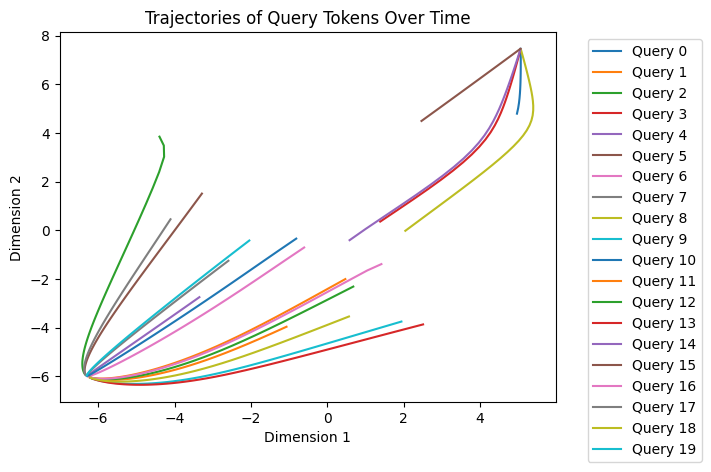

In [128]:
for i in range(n):
    plt.plot(q[i, :, 0], q[i, :, 1], label=f'Query {i}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Trajectories of Query Tokens Over Time')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

/scratch/902496/ipykernel_2044085/3458614494.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', n_clusters)


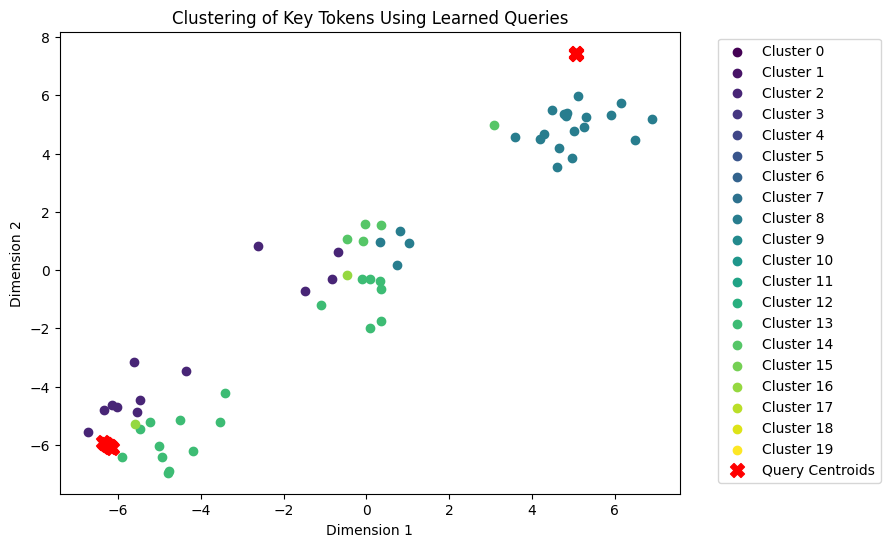

In [129]:
def visualize_clustering_results(input_tokens, q_final, cluster_assignments, title):
    n_clusters = len(q_final)
    colors = plt.cm.get_cmap('viridis', n_clusters)
    
    plt.figure(figsize=(8, 6))
    for i in range(n_clusters):
        indices = np.where(cluster_assignments == i)
        plt.scatter(input_tokens[indices, 0], input_tokens[indices, 1], 
                    color=colors(i), label=f'Cluster {i}')
    
    plt.scatter(q_final[:, 0], q_final[:, 1], c='red', marker='X', s=100, label='Query Centroids')
    
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

visualize_clustering_results(k, q_final, cluster_assignments, 'Clustering of Key Tokens Using Learned Queries')

# for when v and k aren't the same
# distances = cdist(v, q_final)
# cluster_assignments = np.argmin(distances, axis=1)
# visualize_clustering_results(v, q_final, cluster_assignments, 'Clustering of Value Tokens Using Learned Queries')
